# Analysis of Belle2 MonteCarlo Data
### Laboratory for Computational Physics - Modul B

__Authors:__

- Valeria Fioroni (University of Padova)
- Matteo Guida (University of Padova)
- Philipp Zehetner (University of Padova, Ludwig Maximilian University of Munich)
- [Stack Overflow](https://stackoverflow.com/)

__Supervised by:__

- Professor Marco Zanetti (University of Padova, CERN)
- Professor Stefano Lacaprara (University of Padova, BELLE2)

The goal of this project is to find the branching ratio of 
$B^0 \rightarrow \eta' K_S^0$

with $\eta' \rightarrow \eta \; \pi^+ \pi^-$, 
$\eta \rightarrow \gamma \gamma$ and 
$K_S^0 \rightarrow \pi^+ \pi^-$
in Monte Carlo simulation (Data Challenge)

To do this, we build a deep neural network (DNN) with Keras/Tensorflow using labelled data, optimize it and finally use it as a classifier on the Data Challenge

In [1]:
import os, sys, pprint
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
Testing = True # Uses only a small subset of the data and trains on fewer epochs. 
PCA = False
Local_Philipp = True
Local_Valeria = False
VM = False

if Testing: print("For testing purpose only a small number of events are used")
if Local_Philipp : print("Paths are set to be run on Philipps Computer")
elif VM : print("Paths are set to run on the VM")

For testing purpose only a small number of events are used
Paths are set to be run on Philipps Computer


## 1. Reading and Cleaning Data

In this chapter we
- read relevant information from root files into pandas data frames
- clean our data sets by removing wrongly reconstructed signal and allowing only one true signal candidate per event
- apply a $5\sigma$ cut on the mass of the reconstructed $B^0$ on all candidates

In [3]:
# Define branches that we need for our analysis
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal', 'evt_no']

In [4]:
def memory(df):
    print(str((round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2))),"Mb")

In [5]:
from root_pandas import read_root

if Local_Philipp and not VM : 
    path = '/home/philipp/Desktop/Project/DATA/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Continuous/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Peaking/*.root'))
    
elif VM and not Local_Philipp : 
    print('Please set path for VM here')
    
elif Local_Valeria:  
    path = '/home/utente/Scrivania/Progetto LCP-B/DataBelle2/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    

Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Signal = Signal[Signal['B0_isSignal']==1].reset_index(drop=True)
Continuum_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

print ("Memory used by Signal", memory(Signal))
print ("Memory used by Continuum", memory(Continuum_bkg))
print ("Memory used by Peaking", memory(Peaking_bkg))

Welcome to JupyROOT 6.16/00


/home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.4 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


71.3 Mb
Memory used by Signal None
77.18 Mb
Memory used by Continuum None
0.49 Mb
Memory used by Peaking None


### $5\sigma$ Cut on Reconstructed $B^0$ Mass

The reconstructed mass of the $B^0$ will differ for various reasons: 

- If an event is correctly reconstructed detector inaccuracies of all measured decay particles will add up. The estimated error for each candidate due to this can be found in the branch *B0_ErrM* and is part of our data frame. 
- If the event however is not correctly reconstructed the $B^0$ mass is not necessarily a meaningful quantity an can be far of the desired [PDG](http://pdg.lbl.gov/) value. 

By applying a generous $5\sigma$ cut we already lose a significant amount of backround

In [6]:
#Masses from PDG
M_B0 = [5.27955, 0.00026]
M_K0 = [0.497611, 0.000013]
M_etap = [0.95778, 0.00006]
M_eta = [0.547862, 0.000017]

#Require the B0 mass to be within 5 sigma from PDG value
Signal = Signal[abs(Signal['B0_M'] - M_B0[0]) < 5 * Signal['B0_ErrM']]
print(Signal.shape)

Continuum_bkg = Continuum_bkg[abs(Continuum_bkg['B0_M'] - M_B0[0]) < 5 * Continuum_bkg['B0_ErrM']]
print(Continuum_bkg.shape)

Peaking_bkg = Peaking_bkg[abs(Peaking_bkg['B0_M'] - M_B0[0]) < 5 * Peaking_bkg['B0_ErrM']]
print(Peaking_bkg.shape)

#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)
Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

print(Signal.shape)
print(Signal['evt_no'].nunique())

Signal=Signal[Training]
Continuum_bkg=Continuum_bkg[Training]
Peaking_bkg=Peaking_bkg[Training]

(213579, 85)
(120103, 85)
(933, 85)
(212354, 85)
212354


## 2. Data Preprocessing

In this chapter we
- label our data
- turn the label into one-hot vectors as this format is needed by Keras
- split signal, continuum and peaking separatly into training (50%), valdation (30%) and testing (20%) to assure to have a fair amount of each type in all sets
- combine and shuffle signal, continuum and peaking for training, validation and testing, making sure that the labels are shuffled with the same permutation as the data
- standardize the data (removing mean and scaling the standard deviation to 1)
- perform a Principal Component Analysis (PCA) and use the principal components necessary for 99% of the variance

In [7]:
from random import seed
from random import randint

n_seed=1234
seed(n_seed)

In [8]:
Signal['Type'] = 2
Continuum_bkg['Type'] = 1
Peaking_bkg['Type'] = 0

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#SIGNAL: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Signal.drop('Type',axis=1)
Y = Signal['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)

#CONTINUUM BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Continuum_bkg.drop('Type',axis=1)
Y = Continuum_bkg['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)

#PEAKING BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Peaking_bkg.drop('Type',axis=1)
Y = Peaking_bkg['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

del(Signal)
del(Peaking_bkg)
del(Continuum_bkg)

Using TensorFlow backend.


In [10]:
#Define Training, Validation and Test datasets
X_Train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_Validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_Test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)

Y_Train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_Validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_Test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)

print(X_Train.shape)
print(X_Validation.shape)
print(X_Test.shape)

print(X_Train.nbytes/(1024 ** 2), "Mb")
print(X_Validation.nbytes/(1024 ** 2), "Mb")
print(X_Test.nbytes/(1024 ** 2), "Mb")
n_classes = Y_Train.shape[1]


#shuffle the dataset
permutation = np.random.permutation(X_Train.shape[0])
X_Train = X_Train[permutation]
Y_Train = Y_Train[permutation]

permutation = np.random.permutation(X_Validation.shape[0])
X_Validation = X_Validation[permutation]
Y_Validation = Y_Validation[permutation]

permutation = np.random.permutation(X_Test.shape[0])
X_Test = X_Test[permutation]
Y_Test = Y_Test[permutation]

(166694, 83)
(100017, 83)
(66679, 83)
52.77863311767578 Mb
31.667369842529297 Mb
21.111896514892578 Mb


In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)
X_Validation = ss.transform(X_Validation)

### PCA
PCA is a method often used to reduce the dimensionality of a data set. Orthogonal transformations are performed on the data set to find the directions with the highest variance. The rotated features (principal components) are sorted in descending variance. 
The assumption made is, that high variance corresponds to more information and little variance can be neglected as noise. 

In our example we require to keep 99% of the total variance and thus can reduce the number of components from 83 to 50

12 variables explain 50% of the variance
36 variables explain 90% of the variance
42 variables explain 95% of the variance
50 variables explain 99% of the variance


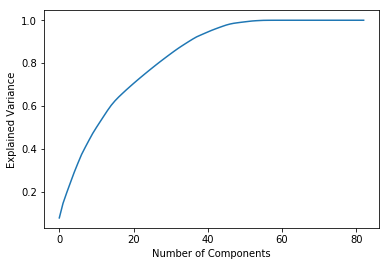

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

if PCA : 
    pca = PCA(n_components=len(Training))
    pcTrain = pd.DataFrame(data = pca.fit_transform(X_Train))
    pcTest = pd.DataFrame(data = pca.transform(X_Test))
    pcValidation = pd.DataFrame(data = pca.transform(X_Validation))

    T50, T90, T95, T99, = False, False, False, False
    for i in range(len(pca.explained_variance_ratio_)) : 
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.5 and T50 ==False) : 
            print(str(i+1) + ' variables explain 50% of the variance')
            T50 = True
            n_50 = i + 1 
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.9 and T90 ==False) : 
            print(str(i+1) + ' variables explain 90% of the variance')
            T90 = True
            n_90 = i + 1
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.95 and T95 ==False) : 
            print(str(i+1) + ' variables explain 95% of the variance')
            T95 = True
            n_95 = i + 1
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.99 and T99 ==False) : 
            print(str(i+1) + ' variables explain 99% of the variance')
            T99 = True
            n_99 = i + 1
        
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.show()
    
else : 
    pcTrain = X_Train
    pcTest = X_Test
    pcValidation = X_Validation

In [15]:
from sklearn.externals import joblib

if PCA : joblib.dump(pca, 'Scaler.pkl')
else : pass

/home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
# For input_dim chose n_50, n_90, n_95 or n_99 depending on how much explained variance we require
if PCA : 
    input_dim = n_99
    pcTrain = pcTrain.iloc[:, 0:input_dim]
    pcTest = pcTest.iloc[:, 0:input_dim]
    pcValidation = pcValidation.iloc[:, 0:input_dim]
else : input_dim = 83

## 3. Create the Neural Network 

In [17]:
optimizer = ['SGD', 'Adam']
epochs = [10, 30]
if Testing : epochs = [1, 2]
batch_size = [100, 1000]
if Testing : batch_size = [1000]
architectures = [ [50, 50], [50, 100, 50], [50, 100, 100, 50] ] 
if Testing : architectures = [ [50, 50] ]
activation = ['relu', 'elu']

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier

def build_DNN(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(pcTrain.shape[1],)))
    model.add(Dense(layers[0], input_shape=(pcTrain.shape[1],), activation='relu'))
    for i in range(1,len(layers)):
        model.add(Dense(layers[i], activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

def print_results() :
    print("Layers: ", layers)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params): 
        print("%f (%f) with %r" % (mean, stdev, param))

In [39]:
pcTrain.shape[1]

50

In [19]:
from sklearn.model_selection import GridSearchCV

results = []
grids = []
for architecture in architectures : 
    layers = architecture
    print("Using architecture: ", layers)
    model = KerasClassifier(build_fn=build_DNN, batch_size=10000, epochs=2)
    param_grid = dict(epochs=epochs, batch_size=batch_size,
                      activation=activation, optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        n_jobs=-1, pre_dispatch=8)
    grid_result = grid.fit(pcTrain, Y_Train)
    results.append(grid_result)
    grids.append(grid)
    print_results()

Using architecture:  [50, 50]


/home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
W0718 18:17:27.554699 140065919186752 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 18:17:27.570975 140065919186752 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 18:17:27.574329 140065919186752 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placehold

Epoch 1/2
166694/166694 [==============================] - 1s 7us/step - loss: 0.0610 - acc: 0.8916
Epoch 2/2
166694/166694 [==============================] - 1s 4us/step - loss: 0.0249 - acc: 0.9528
Layers:  [50, 50]
Best: 0.976922 using {'activation': 'elu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'Adam'}
0.972237 (0.000504) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'SGD'}
0.973016 (0.000471) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'Adam'}
0.976178 (0.001086) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'SGD'}
0.976046 (0.001076) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'Adam'}
0.972758 (0.000705) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'SGD'}
0.973574 (0.001439) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'Adam'}
0.976604 (0.000751) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 2

Using TensorFlow backend.
W0718 18:16:56.157577 140720275347264 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

Using TensorFlow backend.
W0718 18:16:56.167418 139855766226752 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 18:16:56.171578 140720275347264 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 18:16:56.173075 140720275347264 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backen

In [20]:
scores = []
params = []
for result in results : 
    scores.append(result.best_score_)
    params.append(result.best_params_)
    pprint.pprint(result.best_score_)
    pprint.pprint(result.best_params_)

0.9769217845097669
{'activation': 'elu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'Adam'}


### Evaluate the best Network

In [21]:
Best_Score = max(scores) # Best Score: 
Best_Params = params[scores.index(Best_Score)]
Best_Arch = architectures[scores.index(Best_Score)]
layers = Best_Arch
Best_Model = build_DNN(optimizer = Best_Params['optimizer'],
                       activation = Best_Params['activation'])
Best_Model.fit(pcTrain, Y_Train, batch_size = Best_Params['batch_size'],
               epochs = Best_Params['epochs'])

Epoch 1/2
166694/166694 [==============================] - 1s 6us/step - loss: 0.0703 - acc: 0.8794
Epoch 2/2
166694/166694 [==============================] - 1s 4us/step - loss: 0.0257 - acc: 0.9515


In [22]:
Best_Model.evaluate(pcTrain, Y_Train)

166694/166694 [==============================] - 2s 13us/step


[0.011776625099647725, 0.9792254070325314]

OMP: Info #250: KMP_AFFINITY: pid 18388 tid 18587 thread 7 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 18388 tid 18588 thread 8 bound to OS proc set 0


In [23]:
train_prediction = Best_Model.predict(pcTrain)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

In [24]:
train_pred

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [25]:
train_prediction

array([[0.00464296, 0.00118804, 0.9977877 ],
       [0.01425552, 0.96037364, 0.04772294],
       [0.02030554, 0.92128694, 0.0807384 ],
       ...,
       [0.02145439, 0.03201768, 0.96178997],
       [0.0079878 , 0.963426  , 0.05343074],
       [0.00532815, 0.01173646, 0.98727906]], dtype=float32)

In [26]:
N_true_peaking = 0
N_false_peaking = 0
for i in range(len(train_pred)) : 
    if Y_Train[i].all() == np.array([1,0,0]).all() : 
        if train_pred[i].all() == Y_Train[i].all() : N_true_peaking += 1
        else : N_false_peaking += 1
        
print ("Accuracy = ", N_true_peaking/(N_true_peaking + N_false_peaking))
print ("N_true_peaking: ", N_true_peaking)
print ("N_false_peaking: ", N_false_peaking)

Accuracy =  1.0
N_true_peaking:  166694
N_false_peaking:  0


In [27]:
print(Best_Model.evaluate(pcTrain, Y_Train))
print(Best_Model.evaluate(pcValidation, Y_Validation))

166694/166694 [==============================] - 2s 11us/step
[0.011776625099647725, 0.9792254070325314]
100017/100017 [==============================] - 1s 10us/step
[0.011762693358089635, 0.9790035693932032]


In [28]:
train_prediction = Best_Model.predict(pcValidation)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

N_true = 0
N_false = 0
for i in range(len(train_pred)) : 
    if np.array_equal(Y_Validation[i], train_pred[i]) : N_true += 1
    else : N_false += 1
        
print ("Accuracy = ", N_true/(N_true+N_false))
print ("N_true: ", N_true)
print ("N_false: ", N_false)

Accuracy =  0.9790035693932032
N_true:  97917
N_false:  2100


In [29]:
print("Trainig Error : ",1-Best_Model.evaluate(pcTrain, Y_Train)[1])
print("Validation Error : ",1-Best_Model.evaluate(pcValidation, Y_Validation)[1])

166694/166694 [==============================] - 2s 12us/step
Trainig Error :  0.02077459296746864
100017/100017 [==============================] - 1s 10us/step
Validation Error :  0.02099643060679679


In [30]:
y_score = Best_Model.predict(pcValidation)
for s in y_score : 
    print(s)

[0.00631762 0.00637704 0.99444294]
[0.0100784 0.4107044 0.4855344]
[5.2212179e-03 6.4614415e-04 9.9787819e-01]
[0.02039391 0.02609956 0.9638989 ]
[0.00269911 0.00208426 0.9969057 ]
[0.00207379 0.9863075  0.00539404]
[0.0054037  0.04650742 0.9594413 ]
[0.00255898 0.9950004  0.00561637]
[0.00518152 0.990754   0.00260797]
[0.00766453 0.00173199 0.99568087]
[0.02086601 0.9232514  0.07736683]
[0.0081493  0.92827594 0.05999547]
[0.0081512 0.1212154 0.8699107]
[0.01744354 0.9973706  0.00566882]
[5.1790476e-04 9.9980932e-01 4.2667985e-04]
[0.01722696 0.07477733 0.88883287]
[0.03832227 0.03943381 0.9722019 ]
[0.01581615 0.01324812 0.9869927 ]
[0.00508821 0.05731186 0.95270616]
[0.00425586 0.9720345  0.16781074]
[0.00574705 0.01476175 0.97896576]
[0.00534183 0.00958306 0.9860359 ]
[0.01302242 0.98046833 0.03858128]
[0.00447237 0.00380009 0.99241483]
[7.4493885e-03 9.9960268e-01 7.3295832e-04]
[0.00799096 0.01406625 0.9842336 ]
[0.03466517 0.02623743 0.9531058 ]
[0.0254989  0.01392379 0.9796308 ]

[2.0123422e-03 9.9997258e-01 2.0489097e-04]
[0.00149852 0.99599767 0.00421736]
[0.00535092 0.00283623 0.9972937 ]
[0.0021297  0.9991956  0.00118437]
[0.00400847 0.00207666 0.9973345 ]
[3.5786629e-04 9.9234670e-01 1.6565472e-02]
[0.00456908 0.00236136 0.99626267]
[0.00259206 0.00492632 0.99437237]
[0.01294875 0.99568474 0.00476572]
[0.00527298 0.02342951 0.98447824]
[0.00753179 0.99838257 0.00299758]
[0.02754885 0.08275262 0.8793274 ]
[0.009307   0.01265639 0.985906  ]
[0.00988173 0.9948945  0.00460893]
[0.01741698 0.00350344 0.9954913 ]
[0.00689515 0.00878373 0.9889041 ]
[0.00742799 0.07094899 0.8980448 ]
[0.01226622 0.01164025 0.98801565]
[3.0443072e-04 4.7707558e-04 9.9891257e-01]
[0.00457385 0.9828626  0.01217219]
[0.00516629 0.00795013 0.99021125]
[0.0105792  0.00774041 0.9883292 ]
[0.00384486 0.00141698 0.99696004]
[0.0072906  0.04507399 0.95112485]
[0.02230576 0.04627126 0.9584144 ]
[0.00514281 0.02572432 0.9734533 ]
[0.00227401 0.00170872 0.9979259 ]
[0.02935502 0.0291349  0.971

[5.4138899e-04 9.9983525e-01 1.4102459e-04]
[0.00992876 0.00407833 0.9918916 ]
[0.02000472 0.01659003 0.9774749 ]
[1.5406609e-03 9.9852479e-01 7.3152781e-04]
[0.00508115 0.01118705 0.98543656]
[0.00306427 0.9949613  0.00357097]
[0.0024263  0.9986312  0.00115797]
[0.02032965 0.94540596 0.09054142]
[1.6717315e-03 9.9942625e-01 9.3564391e-04]
[0.00781652 0.99782324 0.00372186]
[0.00736013 0.00155744 0.99584365]
[0.01600155 0.9765521  0.02783337]
[0.00356403 0.99642795 0.0066672 ]
[2.2224486e-03 9.1534853e-04 9.9837321e-01]
[0.01085454 0.00561082 0.9900671 ]
[0.00683549 0.00377291 0.9939083 ]
[0.00590867 0.02045324 0.9739454 ]
[0.00918099 0.9847847  0.02667847]
[0.01783478 0.00772288 0.98717797]
[0.03731939 0.03448752 0.9440165 ]
[0.01030236 0.0835636  0.8989824 ]
[1.2904406e-05 9.9784100e-01 1.0508895e-03]
[0.00924951 0.9925189  0.01839224]
[0.00995833 0.9878516  0.01239634]
[1.4901161e-07 9.9716842e-01 5.6254864e-04]
[5.3718090e-03 3.5262108e-04 9.9948442e-01]
[1.0459125e-03 7.7873468e-0

[0.0045177  0.00195575 0.9957109 ]
[1.5639961e-03 9.9896693e-01 4.1013956e-04]
[0.02026808 0.97252417 0.03396195]
[0.0030331  0.00579771 0.9927027 ]
[0.00345746 0.00706816 0.9926583 ]
[0.01488107 0.72431505 0.37443215]
[0.00945434 0.09257504 0.9279969 ]
[0.03525892 0.04107174 0.9460449 ]
[7.9110265e-04 6.8962574e-05 9.9987102e-01]
[0.0045189  0.98418236 0.00825846]
[0.00932395 0.01323438 0.98586214]
[0.01347429 0.02463058 0.9723315 ]
[0.01483542 0.01286685 0.9872744 ]
[0.0110088  0.00218457 0.9951334 ]
[0.01365107 0.9848441  0.0199329 ]
[0.00335521 0.00186697 0.99639326]
[0.01511213 0.9912056  0.00793484]
[0.01306987 0.00386956 0.9945126 ]
[0.01259202 0.9897444  0.0072194 ]
[8.582771e-04 9.988946e-01 6.295264e-03]
[0.00731784 0.00833857 0.98376536]
[0.01366776 0.42798883 0.5524373 ]
[3.6635995e-04 3.8751662e-03 9.9566102e-01]
[0.00842029 0.01025468 0.9885137 ]
[3.8936734e-04 9.9376130e-01 3.5547614e-03]
[0.00996038 0.9370078  0.05959135]
[0.02880865 0.9822589  0.02706936]
[0.00497374 0

[2.5078654e-04 3.5184920e-03 9.9752665e-01]
[0.03635314 0.980354   0.02727938]
[0.01099098 0.02087307 0.9739275 ]
[0.00957382 0.01700756 0.9813496 ]
[4.3311715e-04 9.9998552e-01 5.3167343e-05]
[6.0858428e-03 9.9938792e-01 5.6168437e-04]
[0.00720841 0.0026657  0.995273  ]
[0.00973767 0.98351514 0.01174709]
[0.00367799 0.99517065 0.00234365]
[0.00149345 0.03200644 0.9794976 ]
[0.01024833 0.00605765 0.9927867 ]
[0.00118425 0.00170258 0.99739575]
[4.7056973e-03 2.8383732e-04 9.9894476e-01]
[4.0723085e-03 9.9973536e-01 3.1533837e-04]
[0.00473171 0.0064593  0.9937061 ]
[0.0164237  0.00764889 0.98670745]
[0.00489163 0.9983906  0.00298759]
[0.01551607 0.00883532 0.9928112 ]
[0.00704944 0.00155142 0.99779904]
[0.01499754 0.00532025 0.99223185]
[0.00273275 0.06430382 0.9513697 ]
[0.00327149 0.9795811  0.02645278]
[0.01272538 0.9795127  0.02791569]
[3.8189888e-03 9.9956942e-01 3.4680963e-04]
[1.0132790e-06 9.1352296e-01 7.1178168e-02]
[0.00678998 0.01958603 0.9796175 ]
[0.01344851 0.03199264 0.96

[0.0084478  0.00578383 0.99290454]
[0.00970486 0.00183499 0.99732614]
[0.01512578 0.28355765 0.72855926]
[0.01868841 0.05392048 0.9331917 ]
[0.0098123  0.02371708 0.9796014 ]
[0.00826511 0.92537373 0.05685985]
[0.00288659 0.005099   0.9930976 ]
[0.01837596 0.03505999 0.9658984 ]
[0.02930805 0.98222363 0.02814656]
[0.00673267 0.0032979  0.99333096]
[8.4573030e-04 1.1657476e-03 9.9917817e-01]
[0.01370612 0.87930095 0.15584412]
[0.00576159 0.9966068  0.00267133]
[0.00107422 0.9993243  0.0010421 ]
[0.00834826 0.00226128 0.9944866 ]
[0.01163635 0.02535942 0.98352444]
[0.0032846  0.00282967 0.9939447 ]
[0.0021897  0.9977986  0.00458974]
[0.00913027 0.98104864 0.03102508]
[0.01132372 0.00676528 0.9917923 ]
[0.00203806 0.0036546  0.99574184]
[0.00538105 0.00558507 0.99202156]
[0.00889921 0.00159335 0.99600637]
[1.1920929e-07 4.8100948e-05 9.9992085e-01]
[0.00207284 0.99758625 0.0024828 ]
[0.0064069  0.00197744 0.99335754]
[0.0425415  0.02220187 0.9602697 ]
[0.00374797 0.00128916 0.99776053]
[0

[2.1159649e-05 2.9206276e-06 9.9999583e-01]
[2.861023e-06 3.963709e-06 9.999972e-01]
[5.9848726e-03 9.9958813e-01 8.8068843e-04]
[0.01338601 0.9410051  0.08710226]
[2.2938848e-04 3.0929744e-03 9.9709344e-01]
[4.0826201e-03 4.7215819e-04 9.9959207e-01]
[0.00500312 0.00249252 0.9954444 ]
[4.8756599e-05 3.7252903e-06 9.9998617e-01]
[9.8506212e-03 9.9955356e-01 7.5724721e-04]
[0.00095686 0.5817667  0.55127835]
[7.4741244e-04 9.9961054e-01 4.3734908e-04]
[0.00368169 0.00107232 0.9985678 ]
[9.9438429e-04 1.3542175e-04 9.9983370e-01]
[0.01340565 0.04413098 0.9536066 ]
[0.00382355 0.0163548  0.9768995 ]
[0.00657615 0.04714587 0.94397694]
[0.00625023 0.00796336 0.98843384]
[3.2782555e-07 1.1877030e-02 9.9560225e-01]
[0.00572342 0.01846698 0.97617066]
[0.00996134 0.9814038  0.02277988]
[4.422188e-03 9.988514e-01 9.950399e-04]
[0.02375826 0.02344263 0.9651799 ]
[0.01080921 0.00546986 0.9910896 ]
[0.00295842 0.00353861 0.9969727 ]
[0.0048672  0.99455863 0.00640115]
[0.01293659 0.01855758 0.9759260

[0.01388329 0.06618756 0.9551661 ]
[0.00803512 0.01264232 0.9785476 ]
[0.01313546 0.00845662 0.98429996]
[0.00940835 0.00311244 0.9956379 ]
[0.02229404 0.3877718  0.6308752 ]
[0.01201475 0.01375914 0.9883592 ]
[0.0044913  0.00628266 0.9915052 ]
[0.0284473  0.9914     0.02345315]
[2.0530820e-03 9.9878335e-01 6.9460273e-04]
[0.0070844  0.9376848  0.03250852]
[0.00560004 0.00648499 0.9911719 ]
[0.02503783 0.9810575  0.01838353]
[0.00465342 0.00308558 0.99239665]
[0.0116244  0.9850143  0.02014324]
[3.5825670e-03 9.9838346e-01 5.5608153e-04]
[0.00527677 0.02500737 0.97475255]
[0.03536284 0.02619943 0.9540436 ]
[0.03893742 0.08220196 0.9006952 ]
[0.0084911  0.00380519 0.99518263]
[0.00735152 0.00262383 0.9936865 ]
[0.00189248 0.02212605 0.97626203]
[6.854534e-07 9.999806e-01 4.014373e-05]
[0.00988501 0.00583076 0.9904014 ]
[0.01480061 0.00526756 0.9929482 ]
[2.7726293e-03 6.8777800e-04 9.9914324e-01]
[0.01593772 0.0045476  0.99226063]
[0.00573245 0.03979555 0.9589594 ]
[0.00483555 0.9672312 

[1.329124e-03 9.110570e-05 9.997538e-01]
[8.6169243e-03 7.3492527e-04 9.9802136e-01]
[0.01009855 0.00408864 0.9945649 ]
[0.00191763 0.9972631  0.0069482 ]
[0.00926527 0.00867385 0.98808014]
[2.1611154e-03 9.0283155e-04 9.9905759e-01]
[0.00479379 0.99907565 0.00172776]
[0.03143468 0.97186387 0.02951831]
[1.621455e-03 9.998495e-01 3.180802e-04]
[0.0150294  0.00636372 0.99100196]
[0.04217359 0.8974293  0.14500764]
[0.00536937 0.9987331  0.00247929]
[5.2568614e-03 7.5817108e-04 9.9885678e-01]
[0.0137288  0.97485507 0.02196613]
[0.00526768 0.9924567  0.00650352]
[0.0142459  0.02477762 0.9858563 ]
[7.4237585e-04 9.9939132e-01 2.4801493e-04]
[0.02350664 0.03211322 0.96210265]
[0.00707376 0.99279714 0.00789365]
[0.0038704 0.013226  0.9889746]
[0.0055986  0.01385909 0.9801936 ]
[0.01758996 0.03832492 0.954599  ]
[0.00578809 0.00830671 0.9882543 ]
[0.00238866 0.9987184  0.00117576]
[0.01573065 0.00359184 0.9933462 ]
[0.01940265 0.38719192 0.5880799 ]
[0.01308227 0.35699278 0.69910234]
[0.0062076

[0.00923747 0.02366072 0.9642923 ]
[0.00517088 0.99780405 0.00104567]
[0.01219729 0.9860741  0.01668796]
[0.00173822 0.99836075 0.00245461]
[0.00570384 0.00209251 0.9974883 ]
[0.0061084  0.99569917 0.00155026]
[0.00972843 0.00853303 0.9890801 ]
[0.00542465 0.00220582 0.9967816 ]
[0.00865379 0.99279255 0.0095782 ]
[0.02216429 0.08582258 0.91398156]
[0.01714659 0.33679003 0.59343743]
[0.00558424 0.00218666 0.99601   ]
[0.00815007 0.00499284 0.99482524]
[0.01461643 0.9776491  0.02465847]
[0.01448655 0.00865543 0.9853544 ]
[0.01279017 0.01336303 0.9911182 ]
[0.00964648 0.00745293 0.9942979 ]
[4.7236681e-04 1.1396408e-03 9.9870837e-01]
[0.04470059 0.17208055 0.79801315]
[0.00499642 0.00158483 0.99683136]
[0.0110324  0.0025484  0.99189234]
[4.9975216e-03 9.2691183e-04 9.9798191e-01]
[0.01624557 0.00620934 0.9928185 ]
[0.01221895 0.7631587  0.24099144]
[0.02252543 0.02984554 0.96369636]
[0.00435188 0.00684202 0.99547166]
[0.00420472 0.99633616 0.0016636 ]
[0.01054776 0.0067279  0.99415106]
[0

[0.04316828 0.85463065 0.18149117]
[4.1018724e-03 9.9878073e-01 8.9782476e-04]
[0.00958413 0.02952784 0.95237875]
[0.00639355 0.9984542  0.00286907]
[0.00518829 0.00196338 0.99758995]
[0.0044603  0.98560715 0.01505005]
[0.0019204  0.99369586 0.00344533]
[0.00601837 0.20176542 0.8670484 ]
[0.00349981 0.0010404  0.99876267]
[0.01756635 0.01486936 0.9758945 ]
[5.1435828e-04 1.2946129e-04 9.9985051e-01]
[0.01192182 0.98970485 0.01840237]
[0.02409357 0.9895296  0.00603518]
[0.00591943 0.78528464 0.21916911]
[0.01179585 0.0020102  0.99739605]
[0.01492277 0.02228212 0.9710977 ]
[0.02232984 0.02335149 0.9752041 ]
[0.01802263 0.99313474 0.0105333 ]
[0.01582131 0.18009052 0.83136785]
[0.00572643 0.02618864 0.9714141 ]
[1.0901988e-03 4.4754148e-04 9.9910450e-01]
[0.0027588  0.9912325  0.01533222]
[0.00229487 0.8337853  0.22850671]
[1.0792315e-03 9.9979007e-01 4.9245358e-04]
[0.00627941 0.08060852 0.9094654 ]
[1.1553168e-03 5.2687526e-04 9.9960971e-01]
[0.00406143 0.00494081 0.99393713]
[1.0961592

[0.02236834 0.0064137  0.98959637]
[0.01050034 0.00524744 0.9920995 ]
[0.00819933 0.00649959 0.98986304]
[0.02739355 0.98119366 0.03068998]
[5.2487254e-03 8.7678432e-04 9.9826407e-01]
[0.01095718 0.00194857 0.9972656 ]
[5.686730e-03 9.995815e-01 6.099045e-04]
[0.02292556 0.10152516 0.8721583 ]
[0.00812879 0.29864043 0.7883596 ]
[0.00655419 0.00564805 0.99150246]
[1.8022060e-03 9.9954212e-01 3.5247207e-04]
[0.00922778 0.01105461 0.98813057]
[0.00365877 0.00320581 0.9954385 ]
[0.00992781 0.9994837  0.00107351]
[0.02681351 0.96765864 0.01984325]
[2.5549233e-03 8.2790852e-04 9.9935919e-01]
[0.001564   0.00186151 0.99725807]
[1.478523e-03 7.259548e-04 9.989501e-01]
[0.03104034 0.19603205 0.77508974]
[0.00364888 0.02224424 0.96188134]
[0.00478876 0.11568457 0.8769953 ]
[0.00141782 0.01911071 0.9879799 ]
[0.01317579 0.00661552 0.9894958 ]
[0.01682121 0.0104208  0.9860338 ]
[0.00703761 0.00149226 0.997305  ]
[3.4868717e-05 6.8047279e-01 2.4125344e-01]
[1.3396233e-02 9.9925184e-01 8.0177188e-04

[0.01793212 0.00815454 0.9839392 ]
[0.00176635 0.9951508  0.00443393]
[1.4084280e-03 7.2008371e-04 9.9892104e-01]
[0.01397038 0.22020352 0.8204089 ]
[6.1266124e-03 4.4104457e-04 9.9908453e-01]
[0.00450972 0.32543564 0.6011785 ]
[0.03314063 0.25218424 0.73019016]
[0.00629106 0.99360156 0.00791252]
[0.00145888 0.9952187  0.00304881]
[0.01161265 0.01368698 0.98193836]
[0.00269768 0.9986291  0.00196925]
[0.01527587 0.0348784  0.95937324]
[0.00454193 0.999377   0.00140986]
[4.1719377e-03 9.9975419e-01 8.0505013e-04]
[0.01135218 0.01394999 0.9744829 ]
[0.0024381  0.00671464 0.99087286]
[0.04049534 0.01084417 0.981241  ]
[0.02300191 0.02166682 0.9732491 ]
[0.00493622 0.9939569  0.007938  ]
[0.00639173 0.00906014 0.98525065]
[0.01166853 0.05385643 0.948226  ]
[0.01008925 0.9527262  0.05129352]
[0.01363093 0.00623301 0.9914204 ]
[0.01307759 0.99616295 0.00626728]
[0.02870157 0.4382785  0.4792564 ]
[0.00885594 0.00729784 0.98867816]
[0.01396561 0.00572214 0.99050903]
[0.02853417 0.02412555 0.974

[0.0072214  0.9208086  0.09226832]
[0.00404879 0.00250146 0.9947847 ]
[0.00241834 0.9993467  0.00134456]
[6.1854720e-04 9.9968505e-01 1.5345216e-04]
[0.05719477 0.0177322  0.97600067]
[0.00769317 0.9801353  0.02185214]
[0.00349861 0.9951667  0.00937754]
[0.00650364 0.00128478 0.99683034]
[3.787458e-03 9.815991e-04 9.973203e-01]
[0.01429194 0.99310327 0.00946116]
[0.0075272  0.00146815 0.99809444]
[0.0178529  0.02439249 0.9584421 ]
[0.018998   0.00366622 0.9948957 ]
[0.0121319  0.00673079 0.98832077]
[2.5996864e-03 5.4237247e-04 9.9965358e-01]
[0.00548738 0.0021655  0.9977958 ]
[0.01461062 0.9424797  0.04399461]
[3.3327937e-03 3.5381317e-04 9.9905306e-01]
[0.02680093 0.02085391 0.9597169 ]
[0.03703171 0.18288407 0.8360814 ]
[0.00784925 0.00236017 0.9962784 ]
[0.0078139  0.01424453 0.98506916]
[0.00998494 0.04870328 0.9523728 ]
[0.00883943 0.01893482 0.9899188 ]
[1.1976957e-03 9.9984133e-01 3.9753318e-04]
[0.00823793 0.9873879  0.00901702]
[0.0251343  0.99479043 0.00845587]
[0.00616613 0

[0.01398718 0.01718658 0.97420955]
[8.293986e-05 9.988719e-01 6.636679e-04]
[0.00800464 0.987668   0.01725113]
[0.00128379 0.9689727  0.05803794]
[0.01701671 0.9774276  0.02189207]
[0.00507751 0.00499058 0.9916853 ]
[0.01999545 0.02672753 0.9706408 ]
[0.00379503 0.0133104  0.97897136]
[0.01938537 0.02529401 0.96431303]
[0.01270348 0.02296758 0.9726366 ]
[0.04554373 0.0148108  0.97682965]
[0.0023858 0.0057323 0.993387 ]
[0.00148225 0.9978901  0.0015043 ]
[0.00994006 0.00498015 0.99194884]
[0.00143734 0.00632411 0.9927478 ]
[0.04142478 0.01086593 0.9848225 ]
[8.8143349e-04 9.9979740e-01 3.8990378e-04]
[0.00523373 0.9984804  0.0025641 ]
[0.01266372 0.99603856 0.00619665]
[2.0395815e-03 5.7682395e-04 9.9930513e-01]
[0.00597072 0.00517046 0.9940587 ]
[0.00893685 0.00499651 0.99270487]
[0.04322323 0.0724808  0.92208654]
[7.8653395e-03 7.8830123e-04 9.9891818e-01]
[0.01114851 0.06058463 0.9191335 ]
[0.00623706 0.00560963 0.9905744 ]
[0.00440535 0.9635018  0.01840544]
[0.00988981 0.01922968 0.

[0.00843206 0.17798787 0.82126486]
[0.00243127 0.08960393 0.926906  ]
[2.3549795e-04 9.9872875e-01 6.6569448e-04]
[0.01671526 0.02907726 0.9534605 ]
[0.0091126  0.9849854  0.02638257]
[2.8610229e-06 9.9836749e-01 4.2058527e-03]
[0.00427142 0.9893019  0.01687536]
[0.00773016 0.98356736 0.02027419]
[0.0012275  0.00459796 0.9945662 ]
[5.8561563e-04 2.6150048e-03 9.9720967e-01]
[0.00231591 0.97348225 0.0140194 ]
[0.03607753 0.00790527 0.9919486 ]
[0.00326452 0.00350529 0.99553525]
[7.8040659e-03 5.8603287e-04 9.9830091e-01]
[0.00214127 0.0018484  0.9967991 ]
[0.00188962 0.18753818 0.836602  ]
[0.01594648 0.11940473 0.91057324]
[0.01431692 0.00288031 0.9946171 ]
[0.00685012 0.02270278 0.97479844]
[6.1738491e-04 1.3531029e-02 9.8803824e-01]
[0.02491051 0.00760013 0.9875494 ]
[0.00178191 0.30488348 0.6748594 ]
[0.00694245 0.87013906 0.08909839]
[0.00530982 0.98989844 0.01074085]
[0.00234264 0.00447816 0.99418914]
[0.01013535 0.00257164 0.9956107 ]
[0.01363254 0.00316995 0.9957024 ]
[9.3549490

[0.02135274 0.01464388 0.9869906 ]
[0.01532593 0.00565335 0.9887948 ]
[0.00804541 0.02511689 0.97439694]
[2.9977262e-03 3.7610531e-04 9.9945986e-01]
[0.00342628 0.00729966 0.99547005]
[0.00585598 0.0098286  0.9869945 ]
[2.6377738e-03 8.9830160e-04 9.9870312e-01]
[0.01429224 0.02088538 0.97360146]
[0.01066884 0.01038489 0.98653483]
[0.00446299 0.95232457 0.060478  ]
[0.00415197 0.0069057  0.9890912 ]
[3.4040213e-03 9.9739468e-01 9.4634295e-04]
[0.0202086  0.00176004 0.99579996]
[0.00848913 0.03933001 0.97635067]
[1.2572706e-03 9.9957252e-01 4.2912364e-04]
[5.4582655e-03 9.9900651e-01 5.8493018e-04]
[0.00193295 0.00262052 0.9970377 ]
[0.04556242 0.18746918 0.80724806]
[0.01408294 0.99343514 0.01016298]
[0.01011768 0.35428825 0.4915552 ]
[0.006293   0.07020414 0.9178287 ]
[0.01452285 0.9696938  0.02256387]
[5.7679117e-03 9.9975687e-01 3.3274293e-04]
[0.00943023 0.98261136 0.01837248]
[0.03128713 0.06869158 0.9115812 ]
[0.00159818 0.00306123 0.996619  ]
[0.01333684 0.00233823 0.9966576 ]
[

[0.01243159 0.99616134 0.00443426]
[0.00534838 0.0028486  0.99409103]
[0.00866881 0.01693296 0.97635144]
[4.0269792e-03 9.9979126e-01 2.7227402e-04]
[6.0402155e-03 9.9889868e-01 9.8505616e-04]
[0.00193635 0.9990349  0.00151488]
[0.04450396 0.04075637 0.9381392 ]
[5.9766471e-03 6.9344044e-04 9.9900752e-01]
[0.01681879 0.00466233 0.99383104]
[0.00709635 0.03230619 0.9646142 ]
[0.02357286 0.08243594 0.9186926 ]
[0.00219271 0.00207525 0.99752295]
[0.03814635 0.05125836 0.92774755]
[0.0158909  0.99827087 0.00179526]
[0.00449952 0.00524217 0.9917275 ]
[0.02177596 0.79792976 0.11777559]
[0.01056075 0.9820798  0.01310638]
[1.2546778e-05 1.3515651e-03 9.9924684e-01]
[0.0068275  0.01015103 0.9846081 ]
[0.01731104 0.06027398 0.92834616]
[0.00821015 0.00180343 0.9967207 ]
[0.0032692  0.99906147 0.00108215]
[0.00836912 0.03572896 0.9604777 ]
[0.00957257 0.00528866 0.9962908 ]
[0.00232852 0.02132627 0.9884002 ]
[0.01497856 0.9958569  0.00876868]
[6.4128339e-03 9.3868375e-04 9.9782813e-01]
[0.0186621

[0.00510681 0.00311437 0.9950559 ]
[0.0077557  0.97884905 0.04515937]
[0.00669774 0.00106364 0.99863887]
[0.00367084 0.00492823 0.994051  ]
[0.01233751 0.67707896 0.27166763]
[0.00185376 0.00135058 0.9977957 ]
[0.03101942 0.9160663  0.06339958]
[2.5257468e-04 2.4884939e-04 9.9959111e-01]
[0.00378367 0.00282261 0.9968709 ]
[0.03454325 0.0326798  0.96252793]
[0.01806018 0.91921216 0.08729339]
[0.02155265 0.04093367 0.94967556]
[0.00595486 0.9992997  0.00123897]
[0.00516537 0.98760104 0.01546884]
[0.00274265 0.00826654 0.9919704 ]
[0.02250016 0.03603545 0.95345175]
[0.00298265 0.9920461  0.01762161]
[0.00150144 0.9988724  0.00189838]
[0.00153887 0.9973413  0.00109446]
[0.00696948 0.9940343  0.00188988]
[0.0271067  0.20515078 0.78701985]
[0.01167998 0.9871386  0.01998773]
[0.01435614 0.0239754  0.96444297]
[6.9764256e-04 5.3712726e-04 9.9942291e-01]
[0.0084345  0.99855113 0.00234741]
[2.0274818e-03 3.4391880e-04 9.9953616e-01]
[0.02260897 0.02000883 0.9760115 ]
[0.01497254 0.0169608  0.976

[0.00578266 0.99177814 0.00150406]
[0.01879591 0.03582972 0.9561857 ]
[0.01875594 0.00821993 0.99373424]
[3.0882061e-03 9.9985754e-01 1.5783310e-04]
[1.5886724e-03 1.7970800e-04 9.9953103e-01]
[0.01051486 0.06835681 0.9350078 ]
[0.01260653 0.00251782 0.9960586 ]
[0.00152618 0.00886959 0.9915887 ]
[0.00250104 0.00314954 0.997177  ]
[3.0916929e-04 3.4123659e-04 9.9935156e-01]
[0.00116575 0.00597003 0.9919256 ]
[0.00618485 0.01856297 0.98039   ]
[7.4768066e-04 9.9995363e-01 7.4297190e-05]
[4.2311251e-03 9.9972975e-01 5.0100684e-04]
[0.01548243 0.00871211 0.99249995]
[0.03659338 0.19396552 0.80048853]
[0.0135642  0.00334901 0.9948572 ]
[0.0097793  0.0013223  0.99798465]
[0.00408858 0.00996366 0.98958075]
[3.5557151e-03 4.6014786e-04 9.9954844e-01]
[0.00555167 0.0018346  0.99706507]
[0.02043518 0.9974911  0.00665316]
[0.00371468 0.9956001  0.00265244]
[0.02572724 0.04394719 0.9638785 ]
[0.01191628 0.1414577  0.8389314 ]
[1.5498996e-03 9.9908525e-01 5.5256486e-04]
[0.00770861 0.00359258 0.99

[2.8391480e-03 4.6592951e-04 9.9929726e-01]
[0.00162691 0.9973171  0.00244486]
[0.02592435 0.04018474 0.931793  ]
[0.00853997 0.9953436  0.00829679]
[0.01519716 0.9975721  0.00175989]
[0.01291478 0.00581428 0.9908049 ]
[0.00107458 0.01135832 0.9958807 ]
[0.00186062 0.00723413 0.9931843 ]
[0.02708244 0.9807999  0.03194255]
[0.00827718 0.0015097  0.99654615]
[0.00884235 0.04190356 0.96656275]
[0.01211441 0.99704725 0.00602162]
[0.00228357 0.997627   0.00300881]
[0.00301105 0.84838283 0.08731115]
[0.00723734 0.1417653  0.83533525]
[0.01201463 0.05992651 0.92589605]
[0.01944762 0.01486319 0.97306156]
[0.00889903 0.9911736  0.01497307]
[0.00194746 0.00270566 0.99767804]
[0.00557908 0.9989164  0.00164601]
[0.00167257 0.00578615 0.99564624]
[0.01562646 0.0092876  0.98547876]
[0.01325569 0.03611332 0.9584851 ]
[0.0096719  0.07140568 0.9022161 ]
[0.009363   0.12364352 0.8724814 ]
[0.01885766 0.8562092  0.1799466 ]
[0.00326729 0.00628856 0.99227923]
[0.00538814 0.00195557 0.9981277 ]
[0.002381  

[0.00676805 0.0018737  0.99824303]
[0.00200924 0.01656252 0.97846884]
[0.0130119  0.00175878 0.9945854 ]
[0.01755133 0.1493893  0.851531  ]
[0.01764563 0.3588359  0.6490784 ]
[0.00802389 0.23153389 0.6823918 ]
[0.00146934 0.9945005  0.00930151]
[0.00642443 0.01207766 0.99003124]
[0.01389673 0.00216788 0.99565655]
[0.00382501 0.0022282  0.997705  ]
[0.00628126 0.04819879 0.9265741 ]
[0.01579201 0.00736898 0.98898613]
[0.01784581 0.02338883 0.9729191 ]
[0.02013853 0.04520673 0.9416033 ]
[0.0026204  0.00124457 0.9977406 ]
[0.00752047 0.00218913 0.9950348 ]
[4.0562451e-03 9.9937606e-01 9.9116564e-04]
[0.01795402 0.97446835 0.01693228]
[0.00253186 0.9939022  0.00679851]
[0.02150676 0.14350644 0.77275807]
[0.00736564 0.98477924 0.02880988]
[4.6780705e-04 1.7881393e-02 9.7968757e-01]
[1.1899769e-03 4.0414929e-04 9.9884236e-01]
[5.1119924e-04 1.2862086e-03 9.9814296e-01]
[0.00576705 0.00328869 0.995485  ]
[0.00751945 0.01027152 0.9887552 ]
[9.3877316e-06 4.8175454e-04 9.9954998e-01]
[0.0118139

[0.00273573 0.00736618 0.99320996]
[0.00481626 0.0500479  0.9373871 ]
[5.848527e-03 8.945763e-04 9.975244e-01]
[0.00201145 0.48550746 0.45213136]
[0.0224517  0.06486219 0.9395175 ]
[0.01461247 0.00435907 0.9921211 ]
[0.01997989 0.9812963  0.02865094]
[0.00771335 0.0152137  0.9784845 ]
[0.01669264 0.01622117 0.9727644 ]
[0.00972873 0.00206617 0.9955342 ]
[0.00259048 0.00430715 0.99600416]
[2.663076e-03 9.988579e-01 7.710755e-04]
[0.00771254 0.00661454 0.98890376]
[0.01048088 0.9987192  0.00121397]
[0.00502881 0.9963156  0.00533587]
[0.00737831 0.99762535 0.00339568]
[1.8507242e-04 9.9979794e-01 1.4552474e-04]
[0.03156266 0.992858   0.01578385]
[0.006971   0.97399104 0.04545075]
[0.01119047 0.16698825 0.85430586]
[0.0000000e+00 1.0000000e+00 1.0430813e-06]
[0.01702294 0.00398129 0.9926052 ]
[0.0138922  0.01751676 0.9753819 ]
[0.00790569 0.0174585  0.9831402 ]
[0.01079255 0.9454365  0.05795741]
[0.04202494 0.05095968 0.9309958 ]
[0.01074192 0.99449277 0.0054822 ]
[0.01662728 0.90486777 0.

[3.404349e-03 9.993069e-01 7.814467e-04]
[0.02243477 0.00628534 0.99023104]
[0.01279393 0.983404   0.02776068]
[0.01322719 0.0620881  0.9205528 ]
[0.02373174 0.00597593 0.99052906]
[0.0173611 0.0073027 0.9847069]
[0.00791609 0.9435392  0.04154405]
[0.02574277 0.11690357 0.84081554]
[0.00134134 0.00228417 0.9978899 ]
[0.00474909 0.00762495 0.9880171 ]
[4.8050284e-04 3.6090612e-04 9.9925935e-01]
[9.1198087e-04 4.8681498e-03 9.9798250e-01]
[0.00833526 0.01869503 0.9810032 ]
[0.00913361 0.01658869 0.97572166]
[0.00841054 0.95411927 0.05579057]
[0.01123369 0.00336468 0.99261177]
[0.01083705 0.00134751 0.9979278 ]
[0.03064874 0.94233406 0.04947585]
[0.00920379 0.03650501 0.920522  ]
[0.0048897  0.00571615 0.99289334]
[0.00815764 0.00515592 0.9931899 ]
[0.00341743 0.00778437 0.9927016 ]
[0.03877273 0.06748527 0.9103446 ]
[2.9861927e-05 1.0273337e-02 9.8996401e-01]
[0.0144082 0.8420796 0.1826027]
[0.0244585  0.01180279 0.9824836 ]
[7.5059235e-03 9.9887335e-01 9.6163154e-04]
[0.00678968 0.99645

[0.01006091 0.16115925 0.8878715 ]
[0.01366091 0.52607435 0.38601905]
[0.02194607 0.01044345 0.9841423 ]
[0.02040792 0.00832254 0.987249  ]
[0.00137207 0.95631003 0.07617542]
[0.01178166 0.71612793 0.47132745]
[0.00648504 0.00305063 0.99240327]
[0.02475473 0.032543   0.9522178 ]
[8.100659e-03 9.998038e-01 8.354783e-04]
[0.0090009  0.09040451 0.8609389 ]
[0.01742345 0.94638574 0.04525316]
[8.4024668e-04 9.9931991e-01 4.3460727e-04]
[0.0029673 0.3316974 0.5390015]
[0.00359175 0.01472691 0.98383516]
[0.00110152 0.00982049 0.9884115 ]
[0.01016602 0.01622352 0.98071885]
[0.00235176 0.0054172  0.9961288 ]
[0.01536971 0.03587443 0.9676968 ]
[3.0732155e-04 9.9984086e-01 2.8014183e-04]
[0.01035205 0.98167837 0.01619619]
[0.00289255 0.00475964 0.99325204]
[0.00628528 0.32170528 0.7681031 ]
[8.9276731e-03 4.7007203e-04 9.9892962e-01]
[0.00499889 0.9980322  0.00429714]
[0.0098888  0.00315788 0.9946319 ]
[2.5023818e-03 9.9880052e-01 8.7866187e-04]
[0.00432128 0.99836314 0.00113669]
[0.00599894 0.96

[0.00709149 0.00416556 0.9947681 ]
[1.7915964e-03 9.9986523e-01 2.4431944e-04]
[0.00346044 0.99548554 0.0040617 ]
[0.01048857 0.00709346 0.99357235]
[5.6877732e-04 9.9969375e-01 1.7732382e-04]
[0.00551447 0.9945533  0.00581107]
[0.01997226 0.9854093  0.01935634]
[0.0032697  0.00814834 0.9903631 ]
[4.6639442e-03 7.9035759e-04 9.9793291e-01]
[0.00199923 0.9971888  0.00537542]
[1.3671815e-03 9.9966240e-01 7.2932243e-04]
[0.00599357 0.97123873 0.05081698]
[0.00207856 0.00115705 0.99756503]
[0.00908282 0.9907205  0.00905845]
[0.0016548  0.99749124 0.00334841]
[0.01365054 0.00979823 0.99092424]
[0.00172967 0.9960804  0.00252432]
[0.02734822 0.01812592 0.9682863 ]
[0.01846138 0.02217919 0.97715724]
[6.0975850e-03 2.5951862e-04 9.9944401e-01]
[0.01386809 0.9739567  0.02486905]
[0.00851253 0.99927455 0.00117138]
[0.0000000e+00 9.9995589e-01 2.1755695e-06]
[0.00577927 0.01217264 0.9893087 ]
[0.00330684 0.01460117 0.97898614]
[0.00478512 0.9558148  0.05517289]
[0.00987127 0.00374982 0.99281275]
[

[0.0072768  0.9928093  0.00946563]
[0.02365527 0.01002452 0.9868431 ]
[0.01219067 0.00829101 0.9862993 ]
[0.01556936 0.02109504 0.95705354]
[0.00989461 0.99862504 0.00269392]
[0.00484174 0.97635907 0.01975417]
[0.01430497 0.86068726 0.16003606]
[0.00680408 0.00374052 0.9952041 ]
[0.01107335 0.9967015  0.00466082]
[0.00515091 0.00725302 0.9902979 ]
[0.00397095 0.01238298 0.99192655]
[9.2780590e-04 1.9335747e-04 9.9965811e-01]
[0.0000000e+00 9.9999034e-01 5.9008598e-06]
[3.1146109e-03 9.9965125e-01 5.4755807e-04]
[0.00611711 0.00983137 0.9839747 ]
[0.00873682 0.9914373  0.00346416]
[0.00324482 0.00238329 0.9942888 ]
[0.00191939 0.99897397 0.00183308]
[0.00184795 0.99931645 0.00624564]
[0.0259977  0.9749583  0.02224842]
[0.00918955 0.00989985 0.9826851 ]
[1.7275214e-03 9.9936193e-01 7.7715516e-04]
[0.01103255 0.06485581 0.93023336]
[0.02365202 0.00434595 0.99279416]
[0.00688845 0.02928773 0.96253043]
[0.00418684 0.00336009 0.99554694]
[0.00746548 0.99483454 0.00857431]
[0.01594839 0.96752

[0.01272139 0.9693882  0.03491381]
[0.00839171 0.9978123  0.00289601]
[0.00115043 0.00100246 0.99766916]
[0.02078062 0.7893267  0.32435238]
[0.00914466 0.00864816 0.98954153]
[0.00615358 0.00734875 0.9872297 ]
[2.455175e-03 9.994713e-01 2.387464e-04]
[1.2516975e-06 1.5732646e-04 9.9994779e-01]
[0.04039624 0.03814763 0.9362408 ]
[3.0100346e-06 1.1205673e-05 9.9999738e-01]
[0.01087293 0.00774378 0.9879255 ]
[0.02089635 0.1104033  0.8402239 ]
[0.03759423 0.03356272 0.95175767]
[2.3143291e-03 9.9798059e-01 8.3982944e-04]
[5.9971511e-03 9.3543530e-04 9.9777466e-01]
[0.00416815 0.00180972 0.9965294 ]
[0.00982049 0.9951029  0.00463057]
[0.0010294  0.00409585 0.99550045]
[0.00599393 0.00722337 0.98830193]
[0.00276482 0.01004106 0.9891336 ]
[0.00396895 0.00742635 0.9881377 ]
[0.01237625 0.01477289 0.9797723 ]
[0.00133768 0.00731501 0.98995864]
[0.03342524 0.02004185 0.97727716]
[0.0025923  0.9987247  0.00137812]
[8.4087253e-04 9.9977565e-01 1.4755130e-04]
[0.03583494 0.9986844  0.00204262]
[0.0

[0.0180763  0.00981221 0.99048436]
[0.00905874 0.03473139 0.9620395 ]
[0.00509036 0.9929985  0.00974253]
[0.00976673 0.00618955 0.9912248 ]
[6.7063868e-03 8.8959932e-04 9.9862504e-01]
[0.01948324 0.8656537  0.19732279]
[0.00259829 0.00268275 0.9972577 ]
[0.00788966 0.9585796  0.04473901]
[0.01000741 0.00260782 0.99622273]
[0.01631173 0.00531465 0.9892181 ]
[0.01331133 0.3741988  0.5412103 ]
[0.00142649 0.02181125 0.984642  ]
[0.00190142 0.0012171  0.99881864]
[1.4468133e-03 9.9933010e-01 1.7476082e-04]
[0.00556239 0.00141805 0.9966476 ]
[0.00150225 0.00145355 0.99797213]
[0.02224776 0.01295596 0.97863173]
[4.185021e-03 9.991449e-01 7.942915e-04]
[0.00416249 0.97195745 0.04517362]
[0.00851178 0.99717396 0.00196174]
[0.01590168 0.07949749 0.9007534 ]
[1.6489625e-03 9.9973786e-01 2.5999546e-04]
[0.02403086 0.02954444 0.96593916]
[0.00735539 0.998406   0.00121972]
[0.02264458 0.06637561 0.93866944]
[0.02147985 0.18918228 0.7930963 ]
[0.00474742 0.05397135 0.94590986]
[0.0084978  0.9991693 

[0.02078721 0.01923323 0.98363596]
[0.00206095 0.01375908 0.99107033]
[1.3758957e-02 9.9887252e-01 9.6595287e-04]
[0.00235802 0.99566877 0.00300893]
[0.01433003 0.09365159 0.85567945]
[0.00465328 0.994627   0.0060055 ]
[0.01200849 0.00650975 0.9913795 ]
[1.4047384e-02 9.9980640e-01 7.5206161e-04]
[0.0343706  0.02590668 0.9648824 ]
[0.00376159 0.01973975 0.9839716 ]
[0.00270811 0.964453   0.05744195]
[0.02070814 0.00826016 0.9849687 ]
[0.01440015 0.01227263 0.9855099 ]
[0.00443637 0.03009254 0.9818351 ]
[8.2129240e-04 3.6448240e-04 9.9935746e-01]
[0.00983468 0.9988948  0.00226963]
[0.00519204 0.9963784  0.00388753]
[0.00975224 0.00881684 0.98913145]
[0.01598963 0.14063156 0.8391923 ]
[0.00690088 0.00404707 0.99421537]
[0.00508147 0.99276674 0.01788867]
[4.3529272e-04 1.3695657e-03 9.9881488e-01]
[0.01573595 0.00310084 0.9958628 ]
[0.00537384 0.00725955 0.98588   ]
[4.7247410e-03 9.9877524e-01 9.4094872e-04]
[0.01076499 0.00309879 0.9953987 ]
[0.02849928 0.12088123 0.8894403 ]
[0.0243984

[0.00174001 0.3826642  0.48864692]
[0.01154867 0.00719085 0.9857811 ]
[0.00510332 0.00374904 0.9957908 ]
[0.01302761 0.06598449 0.9497423 ]
[0.01569557 0.11222014 0.87145567]
[0.04933137 0.6702612  0.28113163]
[0.02705413 0.9879117  0.01452726]
[0.00525185 0.10023612 0.9260117 ]
[0.00628534 0.00297186 0.9961908 ]
[0.00291425 0.01762694 0.9790871 ]
[0.01674822 0.00378039 0.9929576 ]
[0.00828442 0.08705866 0.8797512 ]
[0.00195909 0.02091032 0.9827955 ]
[0.01131538 0.00470158 0.99165547]
[0.01792955 0.01097396 0.9894159 ]
[0.00135994 0.01260632 0.97784346]
[0.00480333 0.9785427  0.01923093]
[0.00538564 0.00622746 0.99432755]
[0.00739726 0.02647197 0.9661584 ]
[0.0090903  0.04496878 0.9356955 ]
[0.00843912 0.9842754  0.02687302]
[0.00667077 0.07609704 0.95110023]
[7.3942542e-04 3.5793483e-03 9.9689281e-01]
[0.02500889 0.01312205 0.97867227]
[0.01354593 0.0152216  0.9752912 ]
[1.009047e-03 5.840063e-04 9.990335e-01]
[0.00487477 0.00141463 0.9973247 ]
[0.01208416 0.00820249 0.98582315]
[0.00

[0.01437384 0.96479654 0.05196863]
[0.03655997 0.02107644 0.9698178 ]
[0.00659886 0.00546065 0.9901289 ]
[0.00579461 0.00501215 0.9918854 ]
[0.02033332 0.05850777 0.9449338 ]
[0.01262298 0.24234304 0.8250706 ]
[1.8131733e-04 9.4561660e-01 3.4949869e-02]
[0.00996345 0.04035234 0.9562551 ]
[0.01293555 0.00687659 0.9912734 ]
[7.5435638e-04 1.1274815e-03 9.9837327e-01]
[0.00356808 0.9887092  0.00872472]
[0.00494578 0.00168088 0.996742  ]
[0.01817092 0.99514043 0.00324807]
[0.0171901  0.00269052 0.99441475]
[0.00897491 0.99417937 0.01652941]
[0.00556114 0.00399303 0.995211  ]
[0.00637928 0.93426764 0.0999065 ]
[2.6670098e-04 3.2313168e-03 9.9804235e-01]
[0.00304863 0.00569686 0.98907465]
[1.2749434e-04 9.9978352e-01 3.3083558e-04]
[0.00545427 0.9984909  0.00277594]
[0.03272173 0.94384027 0.07453912]
[7.0571899e-05 1.6833276e-02 9.7603214e-01]
[0.01504368 0.9928634  0.00787333]
[1.8984675e-03 9.9973160e-01 3.4737587e-04]
[0.00141716 0.00162151 0.9980771 ]
[2.8598309e-04 3.6469102e-04 9.99617

[0.02185166 0.0285885  0.96179503]
[0.01315188 0.00380999 0.9943436 ]
[0.02832645 0.15034816 0.82611096]
[0.0117909  0.00996885 0.99111366]
[0.00887653 0.98194563 0.03156912]
[0.01256499 0.12379369 0.8659805 ]
[0.00847587 0.00107551 0.99789566]
[0.00568008 0.8592645  0.24796051]
[0.00961888 0.00682431 0.98412156]
[0.01362279 0.0105103  0.9784305 ]
[0.01392087 0.02013493 0.9712564 ]
[0.00600883 0.00748202 0.9925575 ]
[6.492436e-04 9.974580e-01 8.561909e-04]
[2.4712086e-04 9.7349203e-01 3.1918228e-02]
[2.2434294e-03 9.9978733e-01 2.7304888e-04]
[0.00552693 0.00273848 0.99682295]
[3.7146509e-03 4.7194958e-04 9.9921060e-01]
[0.00259057 0.9964413  0.00762555]
[0.01489422 0.0104371  0.9808123 ]
[0.00425658 0.9985688  0.00345653]
[0.00293165 0.03705809 0.970086  ]
[0.00926134 0.9946341  0.00580209]
[0.00502047 0.61020225 0.5433477 ]
[0.01055911 0.00784129 0.9893966 ]
[0.0213646  0.00561976 0.987279  ]
[0.00938913 0.00102434 0.99779654]
[0.0285995  0.02678159 0.96831036]
[0.01175261 0.9978833 

[0.01275989 0.9586327  0.04218885]
[0.00394806 0.99896    0.00138807]
[0.00328934 0.00119647 0.9993775 ]
[0.0036841  0.99456644 0.00330517]
[0.00364122 0.00187781 0.99841714]
[0.00564134 0.99193186 0.00843123]
[0.00451168 0.7048525  0.29806465]
[0.04879481 0.04664284 0.9173615 ]
[0.01364994 0.00655743 0.9886427 ]
[0.00372803 0.00311202 0.9970871 ]
[0.0033187  0.00292268 0.9954227 ]
[0.03801569 0.99473727 0.00956407]
[7.4985623e-04 4.5179129e-03 9.9515784e-01]
[4.3680668e-03 9.9977916e-01 4.9877167e-04]
[0.02047098 0.02870288 0.96322644]
[0.00937793 0.00582412 0.98957705]
[0.01548371 0.22586626 0.740822  ]
[0.01710629 0.97957444 0.03566387]
[0.00713959 0.99866533 0.00196502]
[2.5416017e-03 6.6727400e-04 9.9917978e-01]
[0.00501114 0.00131524 0.996474  ]
[0.00506249 0.00185883 0.9968023 ]
[0.01109359 0.00236273 0.99485564]
[0.0018931  0.00217655 0.9967395 ]
[0.01460257 0.00194308 0.998015  ]
[0.00556484 0.9979942  0.00152382]
[0.0134902  0.00308201 0.9938597 ]
[0.01446518 0.00811312 0.986

[0.00444812 0.01744264 0.9733802 ]
[0.00339639 0.00380659 0.99734974]
[0.00417444 0.98588645 0.01579529]
[8.2552433e-06 9.9934524e-01 4.3171346e-03]
[0.00885546 0.00138363 0.9972712 ]
[1.5206933e-03 9.4351172e-04 9.9833256e-01]
[0.00268385 0.00567457 0.99321526]
[0.02048334 0.00667164 0.9870629 ]
[8.7255239e-04 9.9167138e-01 1.0065049e-02]
[0.02001804 0.9982581  0.00315532]
[0.00681373 0.98056495 0.01987001]
[6.353855e-04 7.961959e-03 9.933328e-01]
[0.00707012 0.00278348 0.9945894 ]
[0.00842667 0.0068275  0.99157107]
[0.00662857 0.00782004 0.98614705]
[0.01066193 0.00599831 0.99261266]
[0.02395374 0.00493348 0.9847402 ]
[0.01728854 0.0159055  0.98773146]
[0.00913131 0.0600597  0.9466399 ]
[0.00573143 0.0019142  0.9954587 ]
[0.01005599 0.99798894 0.00162709]
[0.00875828 0.01844582 0.9754106 ]
[0.00721577 0.8912164  0.13444781]
[0.00857419 0.99529487 0.00563234]
[0.01175359 0.00650018 0.990674  ]
[1.13636255e-04 9.82414365e-01 2.90361047e-03]
[0.00230831 0.9991387  0.0010494 ]
[0.0054426

[0.00237375 0.00272268 0.9962257 ]
[0.0172734  0.01421085 0.9839415 ]
[0.01421511 0.9936272  0.00335813]
[7.0709288e-03 9.9872637e-01 7.6112151e-04]
[0.00633687 0.00340977 0.993621  ]
[0.02268666 0.03338733 0.9666537 ]
[0.00439015 0.05826318 0.9309037 ]
[0.01787981 0.00294012 0.9939995 ]
[0.00194159 0.9969754  0.00387678]
[1.9956529e-03 9.9953955e-01 3.4582615e-04]
[0.00252521 0.01460359 0.984342  ]
[0.01121253 0.00668094 0.9941683 ]
[0.00505856 0.99577785 0.00501847]
[0.00314361 0.855048   0.14908874]
[0.00155252 0.00319669 0.9943687 ]
[1.8897355e-03 9.9960399e-01 5.2294135e-04]
[0.01245278 0.00311074 0.9936043 ]
[0.00517896 0.9986049  0.00106928]
[0.00165799 0.01113161 0.9871519 ]
[0.02214128 0.01104662 0.9799688 ]
[6.9562197e-03 9.5582008e-04 9.9795806e-01]
[0.02476794 0.54697657 0.49909905]
[0.00735411 0.997139   0.00202182]
[0.01064077 0.00263333 0.99533224]
[0.00329128 0.0030877  0.9957732 ]
[0.0059391  0.01165164 0.9857038 ]
[0.00402391 0.00266445 0.9943664 ]
[0.00288725 0.00721

[0.01074347 0.9802567  0.03701201]
[0.04585093 0.9790863  0.03065461]
[0.01709533 0.04136732 0.95332295]
[0.00582877 0.01209402 0.9868059 ]
[0.01510039 0.00241309 0.9962833 ]
[0.00902212 0.01837915 0.9758867 ]
[3.035158e-03 9.984292e-01 9.689629e-04]
[0.0041734  0.00117502 0.99758166]
[0.01034951 0.9946234  0.00914088]
[0.01267028 0.02425551 0.97101605]
[4.9563348e-03 9.8809600e-04 9.9854845e-01]
[0.00712264 0.98175156 0.02239698]
[0.00325441 0.00155905 0.99824554]
[0.0042015  0.99559253 0.00382334]
[0.00420225 0.9953388  0.00492373]
[0.01391137 0.00951517 0.99148995]
[0.00530469 0.0031265  0.99656415]
[3.2445788e-04 9.9994564e-01 7.3909760e-05]
[0.01509807 0.94868386 0.06381524]
[4.110515e-03 7.029474e-04 9.986437e-01]
[8.3932281e-04 9.9472642e-01 2.7861595e-03]
[0.0043934  0.99580705 0.00505763]
[0.02383476 0.71459055 0.3447495 ]
[5.1534176e-04 9.9910164e-01 3.7771463e-04]
[0.0065552  0.98549837 0.0151979 ]
[0.03841615 0.30753803 0.80264723]
[1.4603138e-06 9.9997783e-01 1.9371510e-05

[0.00895289 0.04410124 0.94637907]
[0.00364628 0.38250846 0.675185  ]
[0.03640732 0.04816517 0.9472641 ]
[0.03429216 0.0093236  0.9839437 ]
[0.0199286  0.9456875  0.05919454]
[0.00398448 0.51104885 0.57057786]
[2.0596385e-03 2.9045343e-04 9.9958611e-01]
[8.3360076e-04 2.2991300e-03 9.9689341e-01]
[1.0123849e-04 9.4276667e-04 9.9935496e-01]
[9.7969174e-04 4.2501986e-03 9.9599147e-01]
[5.4647624e-03 5.9148669e-04 9.9897945e-01]
[0.00544286 0.99749213 0.00241593]
[0.04575324 0.99224246 0.00985873]
[0.02297118 0.06648394 0.9215994 ]
[0.00347811 0.00142547 0.99755204]
[0.00149584 0.08293819 0.93691254]
[0.00323007 0.999063   0.00186387]
[0.00360087 0.99550545 0.00393009]
[0.00254434 0.00571936 0.9957582 ]
[0.00341183 0.9933719  0.01204848]
[0.01943031 0.02366489 0.9767724 ]
[0.00449803 0.00128162 0.9985378 ]
[0.00474113 0.12410921 0.8516094 ]
[0.02493364 0.06669134 0.89507204]
[0.00108165 0.00240946 0.9970013 ]
[0.0098415  0.06283829 0.9262768 ]
[5.0956011e-03 5.8376789e-04 9.9859613e-01]
[

[0.00258884 0.00319603 0.99666905]
[0.01418468 0.9971848  0.00575203]
[0.0153428 0.0297786 0.9714657]
[0.00769836 0.9982929  0.00239629]
[0.00112149 0.08876261 0.9188887 ]
[0.00674799 0.00487816 0.9922819 ]
[0.00329    0.00164482 0.997818  ]
[0.00561371 0.9968355  0.00467914]
[0.00237024 0.01991099 0.97217464]
[0.00498211 0.00667733 0.9909969 ]
[0.00375172 0.9954173  0.00408572]
[0.00918248 0.02041593 0.96876216]
[0.00610471 0.9900454  0.0125258 ]
[4.1604042e-03 6.0904026e-04 9.9870175e-01]
[6.4116716e-04 9.9969184e-01 1.1819601e-04]
[4.1415393e-03 9.9928546e-01 2.6002526e-04]
[1.6144812e-03 9.9950671e-01 3.0490756e-04]
[0.02318755 0.9318943  0.08006719]
[0.01265576 0.00491402 0.99215317]
[0.01637471 0.01586792 0.98124087]
[0.02290997 0.03038466 0.9506098 ]
[0.00714418 0.01043111 0.98803663]
[0.02598184 0.23733574 0.74131495]
[0.00700051 0.00712821 0.9893872 ]
[0.0065597  0.02467778 0.97358465]
[0.01963514 0.00521746 0.9937768 ]
[0.02219465 0.9002594  0.16508713]
[0.00222531 0.9610715 

[0.00645518 0.9393483  0.06543884]
[0.0104261  0.00539395 0.9913626 ]
[0.01439348 0.0123792  0.98550135]
[0.00394776 0.00583255 0.9950683 ]
[0.0129042  0.98986506 0.01773602]
[0.0062736  0.00565535 0.9938725 ]
[0.01553771 0.96297103 0.06328928]
[0.01095697 0.9443332  0.06904379]
[2.1706522e-03 9.9934244e-01 8.5365772e-04]
[0.00521034 0.01038605 0.98112565]
[0.00219423 0.00563067 0.98730373]
[6.0904324e-03 9.9939167e-01 8.1005692e-04]
[0.03397942 0.03289163 0.96476305]
[0.00822395 0.02437347 0.9708104 ]
[0.01268557 0.00641015 0.9901254 ]
[0.0016804  0.01382408 0.98374605]
[0.0109652  0.99765086 0.00343546]
[0.00163966 0.06320995 0.959659  ]
[5.4234266e-04 9.9952173e-01 7.4645877e-04]
[0.0014739  0.9992212  0.00186202]
[1.4587939e-03 9.9956036e-01 1.3086200e-04]
[4.2235851e-04 1.6754270e-03 9.9893117e-01]
[0.0047676  0.7546444  0.20422381]
[0.00267497 0.00377879 0.9955704 ]
[0.0034906  0.99478126 0.01660177]
[0.0047898 0.0014753 0.9975245]
[0.00664967 0.9949056  0.01351187]
[0.00835156 0

[0.0017277  0.02327004 0.98090905]
[0.00667346 0.7204853  0.27904683]
[0.00586954 0.00860271 0.98846704]
[0.00523123 0.01916635 0.974489  ]
[0.01284313 0.00916702 0.9860357 ]
[0.00886634 0.00294948 0.9950886 ]
[0.02285096 0.98156875 0.02362919]
[0.01308924 0.97913635 0.0156891 ]
[0.0126991  0.00453889 0.9888718 ]
[0.01094133 0.99236315 0.00829029]
[0.013659   0.9913955  0.01189515]
[0.01474708 0.99828434 0.00262833]
[0.02086562 0.00235096 0.9961122 ]
[0.00612476 0.05359665 0.9646183 ]
[0.0022451  0.00879866 0.9889209 ]
[0.02218151 0.0222131  0.9751068 ]
[0.00970629 0.0025149  0.99333024]
[0.01247978 0.01158157 0.98215663]
[0.00989929 0.08569485 0.92525303]
[4.1827559e-04 2.3525953e-03 9.9850518e-01]
[0.01537713 0.00571847 0.9909115 ]
[0.01203537 0.00381514 0.9909513 ]
[0.01488069 0.98994017 0.01114017]
[1.360029e-03 9.997163e-01 2.695024e-04]
[0.02075282 0.96144915 0.08776551]
[0.00242347 0.9993663  0.00123304]
[0.00149956 0.07816887 0.90560067]
[0.02911267 0.01251197 0.9819888 ]
[0.00

[0.00942984 0.8950693  0.1610541 ]
[0.00178826 0.8435041  0.12143481]
[0.00539383 0.9986485  0.00240862]
[0.01678953 0.01675928 0.9660727 ]
[2.5077760e-03 9.9992383e-01 1.8045306e-04]
[0.00582254 0.00380901 0.99431515]
[0.00922871 0.0088411  0.9841531 ]
[0.0167073  0.01610109 0.9836137 ]
[0.01326242 0.68675834 0.36704558]
[9.7897649e-04 9.9554372e-01 3.6322474e-03]
[0.00533557 0.8217424  0.18810928]
[0.01957163 0.0294441  0.9640249 ]
[0.00137711 0.9977458  0.00136501]
[0.00841746 0.06699201 0.8817667 ]
[0.01141033 0.97121793 0.02794972]
[0.00606725 0.00368431 0.98655045]
[0.01156661 0.9779074  0.03190547]
[0.00071463 0.54910934 0.51109177]
[0.00576359 0.99498487 0.00853541]
[0.00397545 0.9917177  0.00611913]
[5.7399273e-04 1.0787660e-01 8.8415742e-01]
[0.00492102 0.632066   0.47521   ]
[0.00913665 0.01162088 0.9837675 ]
[0.00451931 0.00317603 0.9937862 ]
[0.00835079 0.0531849  0.91829515]
[0.00640905 0.6973603  0.39296094]
[0.0021598  0.00619906 0.9944848 ]
[5.2785873e-04 5.6433678e-04

[0.00557533 0.996573   0.005588  ]
[0.00718579 0.00357884 0.99424636]
[0.00889686 0.01524255 0.98163164]
[0.00388771 0.00525609 0.992712  ]
[0.0192039  0.11438638 0.8743136 ]
[0.02121535 0.978583   0.02599016]
[0.0065091  0.00163665 0.9972702 ]
[0.00329345 0.00275493 0.9949267 ]
[0.0074349  0.01132327 0.98565054]
[0.00406495 0.00694507 0.9912915 ]
[0.04258943 0.0245004  0.96366   ]
[0.01677141 0.00327057 0.9922885 ]
[1.6825497e-03 9.9963641e-01 4.4712424e-04]
[0.01176614 0.00319201 0.9987708 ]
[0.01601666 0.9966527  0.0071691 ]
[0.0016326  0.00498152 0.9953003 ]
[0.0029991  0.00172114 0.9983555 ]
[0.00855681 0.00837329 0.9848665 ]
[0.00648364 0.00424051 0.9952556 ]
[3.9333105e-04 3.5727024e-04 9.9954474e-01]
[1.6140640e-03 2.7066469e-04 9.9946535e-01]
[0.01913056 0.00925639 0.9805206 ]
[2.3368001e-04 9.9973893e-01 2.0912290e-04]
[0.0022724  0.00504467 0.99610686]
[0.00408423 0.9944006  0.00529459]
[0.00303718 0.9939791  0.01071489]
[0.01750901 0.0832032  0.92839104]
[0.00398263 0.99653

[0.00678319 0.99736166 0.00298968]
[0.01782387 0.01847634 0.98782694]
[0.00514984 0.01138183 0.9837652 ]
[0.00998554 0.00183642 0.9967659 ]
[0.00835621 0.00417471 0.9959587 ]
[0.01794404 0.01504442 0.9875513 ]
[2.9146373e-03 9.9973875e-01 6.5979362e-04]
[0.00826833 0.9997281  0.00122306]
[0.00848278 0.00788918 0.9874767 ]
[0.01184601 0.00723439 0.9832736 ]
[0.0025374  0.9994396  0.00109553]
[0.01478359 0.9903468  0.01020125]
[0.010777   0.00836834 0.9921496 ]
[0.02025825 0.01655784 0.97909933]
[7.647276e-04 9.998481e-01 7.548928e-05]
[8.3344281e-03 8.6161494e-04 9.9799836e-01]
[0.00414526 0.00432706 0.9944838 ]
[0.00239035 0.99931884 0.0013448 ]
[0.00503147 0.00190559 0.9959917 ]
[0.00593862 0.00658482 0.99196875]
[4.8404634e-03 9.9966365e-01 3.5497546e-04]
[0.01424479 0.15231037 0.7910788 ]
[0.00754419 0.00265586 0.9958459 ]
[8.2170963e-04 9.9930632e-01 4.4113398e-04]
[0.00212103 0.9980519  0.00473237]
[6.3314140e-03 9.9962699e-01 4.2697787e-04]
[0.0084343  0.00159192 0.997522  ]
[0.0

[0.00449494 0.00399277 0.994504  ]
[0.01659653 0.00397992 0.9947321 ]
[0.0090372  0.00352064 0.99519527]
[0.00335348 0.00159588 0.9975542 ]
[0.00264812 0.99674493 0.00583193]
[0.00387326 0.00300103 0.99271387]
[9.3626976e-04 2.0512938e-04 9.9978000e-01]
[0.01038036 0.01039901 0.9782028 ]
[0.00536081 0.01830581 0.9797542 ]
[0.00746071 0.0075092  0.9921262 ]
[0.00758722 0.9962143  0.00693268]
[1.8492341e-04 3.4578741e-03 9.9733621e-01]
[1.4290512e-03 4.8950315e-04 9.9899149e-01]
[0.00519803 0.02522281 0.97894585]
[0.00792089 0.00779259 0.9877368 ]
[3.7670732e-03 9.9922252e-01 7.7307224e-04]
[0.00601298 0.99863183 0.00223088]
[0.004325   0.00534749 0.9949391 ]
[0.01900977 0.0043093  0.98939604]
[0.01136807 0.00317776 0.993354  ]
[0.00270402 0.0086123  0.9921515 ]
[0.00797239 0.00380695 0.9926785 ]
[0.00541556 0.0017072  0.9950932 ]
[0.01462495 0.00505868 0.992411  ]
[0.00291535 0.02835014 0.97237575]
[0.01246274 0.9984262  0.00359958]
[0.00157046 0.00427577 0.9965339 ]
[4.6787858e-03 5.89

[0.01137379 0.01693332 0.985963  ]
[0.00634989 0.00229406 0.9960374 ]
[0.00538835 0.01082334 0.99159586]
[8.3312392e-04 9.9903882e-01 7.4732304e-04]
[0.00544879 0.0010314  0.99756444]
[0.00623    0.00601161 0.9881964 ]
[0.03191093 0.03572416 0.957577  ]
[0.00240859 0.97285974 0.01230437]
[0.02677166 0.00666478 0.9898659 ]
[0.01309308 0.0117234  0.9783977 ]
[1.1480749e-03 9.9960446e-01 3.7220120e-04]
[0.01833671 0.095853   0.8883318 ]
[2.1457672e-05 4.1854382e-04 9.9978340e-01]
[0.00839469 0.01735079 0.9854977 ]
[0.01223552 0.01038387 0.9870948 ]
[0.03398684 0.00877556 0.98947847]
[0.00742739 0.00871322 0.9890862 ]
[0.00182253 0.00840631 0.9902214 ]
[0.00419888 0.00507769 0.9929579 ]
[0.00321323 0.9939843  0.00946188]
[0.00435242 0.9964751  0.0058215 ]
[4.1228831e-03 7.6410174e-04 9.9882185e-01]
[2.3649931e-03 9.9987614e-01 4.1607022e-04]
[0.00326455 0.99465775 0.00549042]
[0.01920959 0.04911038 0.95365906]
[0.02827546 0.9812331  0.01647982]
[1.9825101e-03 8.1822276e-04 9.9848676e-01]
[

[0.00436801 0.00300425 0.9959033 ]
[0.02087563 0.03043273 0.97292066]
[0.00437558 0.03205249 0.9688153 ]
[0.00486636 0.00480935 0.9931359 ]
[0.00356525 0.00283206 0.9975353 ]
[0.00913844 0.97042185 0.03934619]
[0.00572553 0.00933021 0.9842442 ]
[0.00626454 0.00709143 0.99143755]
[0.00654274 0.00747362 0.9890363 ]
[0.00765595 0.00522852 0.9913715 ]
[0.00189903 0.99721646 0.00254759]
[0.00466716 0.02175796 0.9782777 ]
[0.00614873 0.00201976 0.99742055]
[0.01179835 0.17678192 0.7582742 ]
[0.00497428 0.999458   0.00143859]
[0.00476313 0.00178394 0.9966903 ]
[0.00576359 0.00167391 0.997962  ]
[0.00219184 0.03238621 0.97278   ]
[0.01393265 0.00614887 0.99059844]
[0.0083304  0.9722827  0.03229854]
[0.00118998 0.9977883  0.00176057]
[0.038165   0.14777777 0.8406008 ]
[0.00294438 0.93049216 0.0832887 ]
[0.00330755 0.00121436 0.99861395]
[1.2647510e-03 2.1058321e-04 9.9939895e-01]
[0.00417715 0.01642364 0.983441  ]
[0.00689599 0.26161525 0.81440985]
[0.00768468 0.04124987 0.9456391 ]
[0.02932054

[0.02941805 0.8241825  0.16774511]
[3.7291646e-04 2.9930472e-04 9.9991190e-01]
[0.00454301 0.00214085 0.99650574]
[0.01555666 0.00731823 0.9833716 ]
[5.905330e-04 6.771088e-05 9.998857e-01]
[0.00818944 0.00355011 0.99542636]
[0.01188141 0.01538697 0.979228  ]
[0.00378072 0.00126311 0.9977515 ]
[0.00385627 0.01198113 0.9867764 ]
[0.01246172 0.00972345 0.98747134]
[3.2398403e-03 9.9980223e-01 3.7130713e-04]
[0.01813796 0.00476703 0.9922409 ]
[0.02110049 0.08928865 0.9033708 ]
[0.00349391 0.00978592 0.98915076]
[0.00735718 0.00527856 0.992717  ]
[7.0631504e-06 9.9999547e-01 6.1988831e-06]
[0.01427412 0.00205925 0.99593186]
[0.01026124 0.10553658 0.912469  ]
[0.04427448 0.8462106  0.19413978]
[0.03760743 0.02810067 0.9519124 ]
[0.00601128 0.00328881 0.99487066]
[0.00104749 0.02880979 0.97886664]
[0.01197386 0.03127581 0.95719266]
[0.00790191 0.9987117  0.0014689 ]
[0.03803924 0.02871102 0.9606683 ]
[0.00390926 0.03565326 0.97281796]
[0.01665449 0.02503771 0.9690341 ]
[1.5248954e-03 9.99382

[0.00540969 0.0041666  0.99354887]
[0.01103553 0.00368673 0.99474907]
[0.00687829 0.00140053 0.9976311 ]
[8.764267e-04 3.273189e-04 9.994920e-01]
[0.02593824 0.00930667 0.98213917]
[0.01777998 0.98457575 0.02684385]
[0.00134569 0.00125027 0.99872124]
[0.00610799 0.00422618 0.9947072 ]
[0.02731919 0.01255032 0.98294497]
[0.0164094  0.00202042 0.9965997 ]
[0.00307289 0.00282267 0.99423397]
[0.00635803 0.99771386 0.00133878]
[0.02802312 0.00487572 0.9904008 ]
[0.01064494 0.00240216 0.99498147]
[0.00248373 0.98604465 0.00849625]
[1.989156e-03 9.973161e-01 9.777844e-04]
[0.00156951 0.00118485 0.9988402 ]
[0.02051818 0.03524736 0.95492315]
[0.0028846  0.9978732  0.00181818]
[0.00325283 0.00160486 0.99741626]
[1.1795759e-04 1.5616417e-05 9.9992442e-01]
[0.00893793 0.07282621 0.9327018 ]
[1.2278557e-05 9.9798942e-01 9.9036098e-04]
[0.00536266 0.9964454  0.009096  ]
[0.01030606 0.00802231 0.9914861 ]
[0.00485942 0.00439656 0.9970516 ]
[0.01894459 0.01543573 0.9795134 ]
[0.00552782 0.02298442 0.

[1.7699599e-04 3.4707785e-04 9.9923658e-01]
[0.026557   0.03474489 0.9626603 ]
[6.6960752e-03 8.2856417e-04 9.9871778e-01]
[0.00441691 0.00455573 0.9953704 ]
[0.00411284 0.00147581 0.99890614]
[0.00204399 0.01621369 0.9804365 ]
[0.00620595 0.00146011 0.9949823 ]
[0.01949397 0.99705714 0.00617194]
[0.01481149 0.00677878 0.988289  ]
[0.00640494 0.04512036 0.96407926]
[0.00214574 0.00788251 0.98820496]
[0.01064733 0.00348204 0.99483854]
[1.9626617e-03 8.9943409e-05 9.9983060e-01]
[0.01020405 0.00895861 0.988169  ]
[0.02538025 0.00660515 0.9910126 ]
[5.2168965e-04 1.8470883e-03 9.9874479e-01]
[0.01420048 0.9418236  0.03713024]
[0.03326762 0.9563395  0.03007263]
[0.0000000e+00 1.0000000e+00 5.9604645e-08]
[0.00188333 0.02452561 0.9690368 ]
[0.01109448 0.05439535 0.94074094]
[0.00385767 0.00225121 0.99537146]
[0.02129304 0.04014999 0.9533305 ]
[0.00325179 0.7272699  0.23911816]
[0.0027746  0.9985821  0.00119275]
[2.3054183e-03 9.9896890e-01 5.9732795e-04]
[0.00156596 0.05199349 0.9371283 ]
[

[0.0031431  0.99063987 0.02149156]
[6.9636405e-03 8.9153647e-04 9.9860758e-01]
[3.3646822e-04 9.9999130e-01 1.0281801e-05]
[0.00634128 0.9981775  0.00424254]
[2.6798248e-04 4.8353672e-03 9.9829829e-01]
[0.01584184 0.00426176 0.9930985 ]
[0.01481807 0.00660166 0.99462855]
[1.2601018e-03 7.5599551e-04 9.9917519e-01]
[0.00554773 0.02829224 0.96849746]
[0.00611874 0.01621047 0.9792694 ]
[0.0246118  0.98983455 0.01631397]
[0.00297129 0.02552465 0.9710132 ]
[0.00206941 0.00501582 0.99429774]
[0.0056141  0.99328285 0.00656903]
[3.3268034e-03 9.9970561e-01 3.6635995e-04]
[0.01068163 0.03456438 0.9604818 ]
[4.8757493e-03 5.4115057e-04 9.9831784e-01]
[0.01171386 0.02905133 0.96570885]
[0.00243166 0.00152737 0.9982235 ]
[0.00431538 0.01837531 0.9760995 ]
[9.2470646e-04 9.9966705e-01 4.5543909e-04]
[0.00865966 0.00278643 0.99399304]
[0.01393938 0.00755852 0.98431027]
[4.1608214e-03 7.5623393e-04 9.9880230e-01]
[0.0050312  0.00214916 0.9969529 ]
[0.01176187 0.00250268 0.99184716]
[0.00733259 0.0338

[0.00407639 0.00253353 0.99362516]
[8.8727474e-04 9.9527818e-01 4.3576062e-03]
[0.00616276 0.10188401 0.9025991 ]
[0.00597924 0.46996543 0.55979633]
[0.0105907  0.00186574 0.99622095]
[0.01300558 0.8782378  0.08302733]
[2.3514926e-03 3.0347705e-04 9.9905610e-01]
[0.00413489 0.00146154 0.9972979 ]
[0.01175827 0.992812   0.00643119]
[0.01933327 0.91894233 0.10102743]
[0.00712883 0.00194484 0.9962173 ]
[0.00479668 0.00230899 0.9957373 ]
[0.0122169  0.976035   0.03283569]
[0.00094962 0.6395785  0.36685014]
[0.00197938 0.9769566  0.0163604 ]
[0.01483566 0.00579271 0.99431634]
[0.01247001 0.00139067 0.99757826]
[0.01618409 0.4688301  0.60374707]
[0.00471467 0.9969952  0.00196877]
[7.9395473e-03 6.6167116e-04 9.9796259e-01]
[3.7918687e-03 6.0650706e-04 9.9862230e-01]
[0.00322828 0.00258043 0.99676967]
[0.00607434 0.00376335 0.99545205]
[0.01161522 0.00509593 0.99223685]
[0.00900391 0.00734633 0.9885271 ]
[5.7285428e-03 9.9941349e-01 7.4356794e-04]
[3.4579635e-04 5.4121017e-05 9.9993187e-01]
[

[1.6424060e-03 9.9955094e-01 8.1539154e-05]
[0.01124901 0.02909347 0.97113264]
[0.0050126  0.00132778 0.99868345]
[0.01017171 0.0495058  0.92473567]
[0.00594953 0.9290987  0.0533472 ]
[0.00612867 0.9955233  0.00415167]
[0.01274663 0.07750556 0.9228889 ]
[0.02726111 0.01321557 0.9762399 ]
[1.9857287e-04 9.9926567e-01 2.6935339e-04]
[0.0039663  0.06504339 0.9401901 ]
[0.02038303 0.02249071 0.9664415 ]
[8.7296963e-04 9.0471804e-03 9.9209607e-01]
[0.00467655 0.01142552 0.98655653]
[0.00513604 0.9971039  0.00239938]
[5.8993697e-04 9.9965072e-01 1.5383959e-04]
[0.00880003 0.00590152 0.99202156]
[0.00807282 0.00329906 0.9941597 ]
[0.00764805 0.04039225 0.9300336 ]
[0.00264403 0.9970076  0.00126788]
[0.01367167 0.11210346 0.8852919 ]
[8.3684921e-05 9.9100757e-01 3.1443238e-03]
[0.02546045 0.93277955 0.11232826]
[0.01523498 0.94849646 0.07564816]
[0.00755721 0.00725207 0.990748  ]
[0.00523674 0.06730163 0.92185247]
[0.00465792 0.00178161 0.99557686]
[0.0111163  0.01258826 0.97763634]
[0.0065245

[0.00319758 0.9984584  0.00352639]
[0.00690287 0.0011048  0.997586  ]
[0.01830542 0.00367191 0.9959451 ]
[0.00897297 0.02168381 0.96867406]
[6.892085e-04 9.008348e-03 9.943327e-01]
[0.02711833 0.03827375 0.9624953 ]
[0.01339328 0.0047991  0.99250287]
[0.02783293 0.99013627 0.01346761]
[0.02195162 0.00866014 0.98759925]
[0.01209074 0.00251424 0.99456364]
[0.02027717 0.8672333  0.18907925]
[0.00497869 0.03834793 0.9481307 ]
[0.01326779 0.00324801 0.9964556 ]
[0.01682043 0.01638395 0.9755132 ]
[0.02063036 0.0208123  0.972319  ]
[0.00657338 0.5004267  0.63030815]
[0.00473765 0.9969255  0.00203195]
[0.02311781 0.03028652 0.9584558 ]
[0.01329613 0.00897908 0.98886   ]
[0.01079133 0.00144625 0.9948219 ]
[0.00590637 0.00359839 0.99569297]
[0.00858393 0.0121358  0.9883387 ]
[0.009036   0.9307546  0.10525379]
[0.02597293 0.03558698 0.9610752 ]
[0.00354081 0.46306127 0.6007252 ]
[0.02124619 0.9729963  0.03244263]
[0.01584807 0.9877351  0.01242036]
[4.9206614e-04 9.9846685e-01 8.4683299e-04]
[0.03

[0.0053269  0.00848749 0.9902295 ]
[0.00494581 0.01739654 0.97964275]
[0.00165173 0.07737008 0.93397427]
[0.01752734 0.04592589 0.95540184]
[0.00279599 0.9771395  0.02379924]
[0.01150462 0.00189266 0.9969734 ]
[1.1599362e-03 8.6480379e-04 9.9858016e-01]
[0.0077686  0.99797046 0.00157326]
[1.4175773e-03 9.9846733e-01 8.8012218e-04]
[0.00412616 0.00218511 0.99626374]
[2.2858977e-03 9.9888718e-01 8.1250072e-04]
[0.01017871 0.0048362  0.99378484]
[0.01745123 0.0039441  0.9923878 ]
[0.01868039 0.95064735 0.06903502]
[0.00800812 0.08178115 0.91467834]
[0.00851476 0.9949548  0.01298335]
[0.00309566 0.00367248 0.995913  ]
[0.00642127 0.03485215 0.9555821 ]
[0.00172204 0.03925547 0.97517395]
[6.5207481e-05 3.3461547e-01 7.1481520e-01]
[0.00457114 0.9987776  0.00164238]
[2.914369e-04 9.995527e-01 8.714199e-05]
[0.0158197  0.94983125 0.05162558]
[0.00400978 0.00371265 0.9934087 ]
[0.00804874 0.1836839  0.8820535 ]
[0.00293314 0.02644354 0.9457594 ]
[0.00766602 0.00142071 0.9964175 ]
[0.00892222 0

[0.03381926 0.01742405 0.98411185]
[0.00444132 0.99963677 0.00146264]
[0.00499117 0.00680521 0.99253225]
[0.00609288 0.06131285 0.94292736]
[0.00564304 0.9978917  0.0034169 ]
[0.00340989 0.00257102 0.99582875]
[0.02225265 0.9978386  0.00395003]
[2.6543438e-03 3.6734343e-04 9.9869895e-01]
[0.00258768 0.99788606 0.00280982]
[0.00747463 0.00205266 0.9944462 ]
[0.00349131 0.00571337 0.99420077]
[0.00756401 0.01113549 0.989233  ]
[0.00572431 0.9464984  0.05134764]
[0.006304   0.9953252  0.00569236]
[0.01508936 0.01688871 0.98098034]
[7.9247355e-04 2.0722449e-03 9.9664348e-01]
[0.02047008 0.04785216 0.93992543]
[1.6829967e-03 7.4198842e-04 9.9861151e-01]
[1.9482374e-03 9.9967527e-01 4.7630072e-04]
[0.0137648  0.00991017 0.98448265]
[0.01661152 0.00181982 0.995592  ]
[0.00260568 0.99925363 0.00115651]
[1.3081729e-03 9.7000599e-04 9.9874437e-01]
[1.311630e-03 9.987762e-01 7.135272e-04]
[0.00921756 0.9588587  0.03298208]
[0.0023421  0.00196916 0.9959831 ]
[3.699243e-03 6.504357e-04 9.981444e-01

[0.00286111 0.999094   0.00109977]
[0.0065456  0.08808297 0.8840029 ]
[0.01068014 0.04938072 0.94747055]
[0.01566991 0.96588457 0.04320657]
[1.4007092e-06 6.4285398e-03 9.9516356e-01]
[6.1938167e-04 9.8225248e-01 1.8577278e-02]
[4.8339367e-05 2.5102496e-04 9.9978107e-01]
[0.01250815 0.1661166  0.8245152 ]
[0.02102661 0.92306083 0.09476095]
[0.00215882 0.80219936 0.19094077]
[0.00907916 0.00851303 0.98109835]
[0.02059829 0.01961124 0.97714376]
[0.01094949 0.02739006 0.96628153]
[0.00584963 0.02558857 0.973886  ]
[0.00641239 0.00449252 0.9940407 ]
[0.01117289 0.9621078  0.05031896]
[0.00544488 0.00522062 0.99131614]
[0.03416541 0.00933349 0.9870076 ]
[0.00406283 0.9984941  0.00100872]
[8.6560845e-04 1.4578223e-02 9.9019206e-01]
[0.00973722 0.4960208  0.4889751 ]
[0.00672883 0.05775189 0.9353225 ]
[0.00110325 0.00339836 0.99579823]
[0.00397918 0.5702634  0.37511724]
[6.2066317e-04 6.3233376e-03 9.9575979e-01]
[0.00360349 0.99051636 0.00864226]
[0.01133266 0.00536904 0.98916626]
[0.0067324

[1.1149645e-03 2.3427606e-04 9.9944377e-01]
[8.2600117e-04 9.9975330e-01 2.7590990e-04]
[0.00153863 0.13717848 0.8988711 ]
[0.03181621 0.01362079 0.9911678 ]
[6.9515705e-03 9.9956059e-01 7.5027347e-04]
[0.01298466 0.00244436 0.99601233]
[3.59734893e-03 1.11192465e-04 9.99592245e-01]
[0.01280248 0.997612   0.00433546]
[0.00386077 0.00164098 0.9956031 ]
[0.00607479 0.99737966 0.00196826]
[0.00683644 0.07232156 0.9130125 ]
[0.00307718 0.9386865  0.07751155]
[0.02352723 0.9962462  0.01321387]
[0.02321714 0.98139584 0.02749673]
[0.01903248 0.32989955 0.6078745 ]
[0.00704762 0.0077228  0.9845012 ]
[0.00234497 0.00509244 0.99576783]
[8.940697e-08 0.000000e+00 1.000000e+00]
[0.03052682 0.05725729 0.9393468 ]
[2.0372272e-03 9.9846017e-01 9.2941523e-04]
[1.8197000e-03 7.9861283e-04 9.9756849e-01]
[0.00623122 0.00147524 0.9974196 ]
[2.0078719e-03 4.2673945e-04 9.9908197e-01]
[0.00609565 0.01095638 0.98893046]
[7.1018934e-04 9.9930048e-01 4.1618943e-04]
[1.6877353e-03 9.9902052e-01 8.9728832e-04]


[0.01198587 0.04375514 0.9626607 ]
[0.0068433  0.06733564 0.9110149 ]
[0.01485857 0.99665606 0.0050824 ]
[1.6474724e-04 2.3079813e-03 9.9748445e-01]
[0.00123689 0.9996745  0.00111833]
[4.7337115e-03 9.9968541e-01 8.6110830e-04]
[0.01458395 0.01232827 0.9792539 ]
[0.02100861 0.99463946 0.00658545]
[0.01512563 0.0135504  0.98282385]
[0.00171766 0.0156725  0.98309594]
[0.01129362 0.9390827  0.05006868]
[0.03788263 0.06043252 0.9152057 ]
[0.04709783 0.03700933 0.9535657 ]
[0.02809513 0.00788608 0.9852061 ]
[0.00187069 0.99501693 0.01170298]
[0.0203965  0.055996   0.94095886]
[0.00405386 0.9508633  0.03346169]
[0.01029858 0.90174496 0.13740242]
[0.0440895  0.11627224 0.87364084]
[8.3437562e-04 2.3678303e-02 9.7255111e-01]
[0.00571463 0.01186424 0.98950016]
[0.00456268 0.99131936 0.00785309]
[0.00799125 0.05930835 0.90355366]
[0.00619343 0.23116338 0.69727826]
[0.02312228 0.98870254 0.01324198]
[0.00360686 0.34732896 0.5868529 ]
[0.01214588 0.08673662 0.90607536]
[0.00492805 0.9987641  0.001

[0.00886947 0.9949348  0.00594008]
[7.7311695e-03 9.9928218e-01 7.1868300e-04]
[0.00612587 0.95913893 0.09007049]
[4.4009089e-04 1.7051399e-03 9.9778450e-01]
[0.0131442  0.99841833 0.00325024]
[0.0148778  0.00439569 0.9944815 ]
[0.02613196 0.01790309 0.97188556]
[0.00204623 0.00167152 0.9985051 ]
[0.03249776 0.00619811 0.9897438 ]
[0.03389627 0.01116306 0.9846761 ]
[0.00791225 0.03663221 0.9753742 ]
[9.519756e-04 9.974033e-01 5.257249e-03]
[0.00849518 0.0084053  0.9850973 ]
[1.4993846e-03 9.9961674e-01 3.0922890e-04]
[0.0205051  0.00656003 0.99194014]
[0.03951079 0.9297586  0.11833429]
[0.00863856 0.02689865 0.975545  ]
[0.00665942 0.00436252 0.99292463]
[0.05793646 0.09432727 0.87609625]
[4.2530894e-04 3.6713481e-04 9.9856031e-01]
[0.00487688 0.00643927 0.9892546 ]
[0.01377526 0.00567529 0.98989034]
[0.01126823 0.00768259 0.9922442 ]
[1.1417568e-03 5.3936243e-04 9.9980783e-01]
[0.03465486 0.06360516 0.93877184]
[0.00624278 0.01108727 0.9873151 ]
[0.01020652 0.9634807  0.04128945]
[9.3

[0.02131832 0.01836836 0.9734021 ]
[0.0186587 0.268597  0.774063 ]
[0.0129239  0.9984874  0.00265074]
[0.00515777 0.02485022 0.9756595 ]
[0.04269314 0.0556742  0.9453268 ]
[0.00316435 0.96931565 0.03899291]
[0.00485435 0.01254079 0.99407136]
[0.01907352 0.01518863 0.98174435]
[0.00101882 0.00185913 0.9970633 ]
[0.00117606 0.99865264 0.00103971]
[0.00812769 0.01319912 0.98316765]
[8.3699822e-04 9.9856699e-01 1.2951791e-03]
[0.0043675  0.23269144 0.82174504]
[0.00848719 0.58446705 0.44713962]
[0.00159156 0.19022813 0.7426442 ]
[0.01335892 0.10543692 0.9029462 ]
[0.01961949 0.435717   0.45301372]
[1.8266141e-03 9.9709630e-04 9.9838340e-01]
[0.01549914 0.98423886 0.03105643]
[0.00812343 0.00306129 0.9951757 ]
[0.00466233 0.0071556  0.99287146]
[0.00385892 0.00320682 0.9948289 ]
[0.00480953 0.08804482 0.9216651 ]
[0.00135633 0.9985068  0.00254819]
[0.0018526  0.18784773 0.8187988 ]
[4.8362911e-03 4.1481853e-04 9.9873972e-01]
[0.0073936  0.01227757 0.98971355]
[1.2066215e-02 9.9916005e-01 8.

[7.5794458e-03 9.8717213e-04 9.9839765e-01]
[0.00521138 0.00252205 0.9974797 ]
[0.01167715 0.09900236 0.9160236 ]
[0.0256491  0.9954692  0.00469801]
[1.6211867e-03 9.9883640e-01 8.9836121e-04]
[0.00951615 0.9975505  0.00157371]
[0.01101243 0.003663   0.9926312 ]
[0.00386369 0.05130318 0.9424862 ]
[0.00411823 0.00531194 0.9949715 ]
[0.01431105 0.5786084  0.45352167]
[0.00309291 0.9988941  0.00139382]
[0.01628011 0.00687149 0.9895519 ]
[0.00736651 0.00676012 0.9892582 ]
[0.02278617 0.03535992 0.9577209 ]
[0.0036664  0.07311463 0.9178804 ]
[0.01225847 0.00344744 0.99342954]
[2.4773479e-03 2.3671985e-04 9.9953473e-01]
[0.00209048 0.0046778  0.994146  ]
[0.02454379 0.01072797 0.9834949 ]
[3.9191842e-03 6.5082312e-04 9.9925476e-01]
[0.01009586 0.01226214 0.9879873 ]
[0.01853767 0.00330821 0.99225646]
[0.00266799 0.00207663 0.9968568 ]
[9.5421076e-04 3.2985210e-04 9.9936819e-01]
[0.00323534 0.9972062  0.00189376]
[0.00484586 0.00323117 0.9939187 ]
[0.00609985 0.00268999 0.9915839 ]
[0.0036586

[0.00804424 0.00341603 0.99149394]
[0.00741088 0.9942617  0.00486884]
[0.01125905 0.02066326 0.98338914]
[3.0510128e-03 9.9957883e-01 7.5829029e-04]
[7.512510e-03 5.900264e-04 9.975836e-01]
[1.6808510e-04 9.9994254e-01 3.3766031e-05]
[0.01327172 0.01017213 0.9919038 ]
[0.00226146 0.9951545  0.0082899 ]
[0.01583889 0.9758945  0.02577069]
[0.0088684 0.8913268 0.1308783]
[0.00975621 0.99704313 0.00828668]
[2.2876263e-04 4.4777989e-04 9.9969518e-01]
[0.01316532 0.29532582 0.69298404]
[0.00907975 0.00158823 0.996828  ]
[0.00223571 0.00410575 0.9954978 ]
[0.00894096 0.00476113 0.991218  ]
[0.00463495 0.00139835 0.9968015 ]
[0.00714976 0.02707395 0.96404827]
[9.5054507e-03 5.8677793e-04 9.9918437e-01]
[6.9877505e-04 9.9903929e-01 7.1230531e-04]
[0.01037768 0.9733566  0.0524185 ]
[0.00383529 0.00677472 0.98968554]
[0.00816041 0.00265393 0.99619764]
[0.02798796 0.63386136 0.399645  ]
[0.00611377 0.00300077 0.9966147 ]
[0.00148129 0.00486347 0.99586964]
[0.00489089 0.00214729 0.99591   ]
[3.3808

[0.01121154 0.01418382 0.97836936]
[0.00447476 0.0010983  0.9973292 ]
[0.00139025 0.00106886 0.9985059 ]
[0.00972077 0.92846227 0.06797472]
[0.00895661 0.04323778 0.9411813 ]
[0.00874385 0.8804961  0.09522238]
[0.00808844 0.9957411  0.00555015]
[0.00537595 0.02165461 0.9767748 ]
[0.01099467 0.12955919 0.8559069 ]
[0.007411   0.9988843  0.00137731]
[6.1681867e-04 6.1806113e-01 5.2150512e-01]
[0.0111084  0.9980582  0.00239807]
[0.01142338 0.00616536 0.993086  ]
[0.00278851 0.00126517 0.997747  ]
[1.4964640e-03 2.0569563e-04 9.9982536e-01]
[0.0177843  0.94697344 0.06986815]
[0.00183141 0.00201881 0.9958576 ]
[1.4157295e-03 6.2862039e-04 9.9883103e-01]
[1.2752414e-04 1.7771125e-04 9.9963772e-01]
[6.9579482e-04 1.0983646e-03 9.9873406e-01]
[0.00226548 0.9951805  0.00380227]
[0.00802132 0.00537884 0.9914119 ]
[0.01032418 0.07687151 0.9028578 ]
[0.00148109 0.99825513 0.0018377 ]
[0.01594651 0.00349745 0.9956188 ]
[0.00222617 0.00632086 0.9932854 ]
[0.00453219 0.9400503  0.06230032]
[0.0175529

[4.2633116e-03 9.9863183e-01 9.1245770e-04]
[4.066974e-03 9.990512e-01 6.342232e-04]
[0.0035671  0.9945189  0.00794294]
[4.1139126e-04 9.9992955e-01 8.6456537e-05]
[0.02046439 0.10259542 0.8913646 ]
[0.00431508 0.01337522 0.98036575]
[0.01571843 0.01147246 0.9853021 ]
[0.01730832 0.0390439  0.9355321 ]
[0.01917875 0.02333069 0.96432626]
[0.04144508 0.9263811  0.10011354]
[0.00913945 0.02470067 0.96561265]
[0.00733581 0.9896815  0.02488127]
[0.01125181 0.01035029 0.99137586]
[5.4461658e-03 9.5522404e-04 9.9915755e-01]
[0.01056728 0.9968087  0.00599551]
[0.00769696 0.91022646 0.11644092]
[0.00176758 0.20118296 0.78660333]
[0.02279767 0.02485809 0.94234073]
[0.01226145 0.00487691 0.9898224 ]
[0.01539078 0.00373146 0.99428403]
[1.5903115e-03 3.5172701e-04 9.9970812e-01]
[1.1400580e-03 9.9956316e-01 3.9100647e-04]
[0.00196549 0.00836799 0.9932741 ]
[0.0151827  0.01352683 0.9868889 ]
[1.0924041e-03 1.9910932e-04 9.9980533e-01]
[0.02269244 0.00931785 0.9836991 ]
[0.00985613 0.10139591 0.91316

[0.00393352 0.01163068 0.98449254]
[0.02211678 0.23639515 0.71165895]
[0.02537894 0.01212451 0.9779763 ]
[5.9556961e-04 3.2093525e-03 9.9769008e-01]
[0.00491905 0.9866206  0.01366401]
[0.00173911 0.00782114 0.9890393 ]
[0.00215226 0.9925931  0.00570187]
[0.00780889 0.00141656 0.99568224]
[2.5752187e-04 9.2988080e-01 2.4601877e-02]
[0.0557397  0.24084735 0.74835336]
[0.02161264 0.05239561 0.9242614 ]
[0.03841978 0.0298301  0.95881546]
[0.01396573 0.01731047 0.97779256]
[0.0204908  0.0408363  0.95281345]
[0.02175227 0.29281032 0.688813  ]
[0.00612599 0.00831789 0.98651683]
[0.01768467 0.99934685 0.00206643]
[8.6134672e-04 9.8755956e-04 9.9867475e-01]
[0.01226267 0.11061084 0.85842204]
[0.002606   0.00322104 0.9933531 ]
[0.00479573 0.00155586 0.9970974 ]
[0.01221836 0.8525907  0.20064116]
[0.00948825 0.01422754 0.9801955 ]
[0.00140122 0.9968258  0.00414413]
[0.01927289 0.00395277 0.9920869 ]
[0.00775144 0.00579551 0.9900609 ]
[0.00554916 0.9935627  0.00676522]
[0.00109258 0.00103784 0.998

[0.00727329 0.02614915 0.9764613 ]
[0.00531167 0.9518969  0.05214098]
[0.00379705 0.92776895 0.11513293]
[1.1054873e-03 9.9841624e-01 5.9676170e-04]
[0.00423083 0.99903476 0.00182226]
[0.01022142 0.00326994 0.9950949 ]
[0.00864893 0.00180119 0.99573004]
[0.00151181 0.5482642  0.5206132 ]
[0.00462362 0.98822385 0.00810754]
[0.01826879 0.01334521 0.98288184]
[0.0052008  0.00635466 0.99334043]
[0.00857395 0.0103963  0.9859352 ]
[7.2720647e-04 1.7567277e-03 9.9833608e-01]
[0.0029009  0.00153196 0.99856496]
[0.01338199 0.00397721 0.9943279 ]
[0.00602368 0.00655475 0.99009657]
[0.00499243 0.9990299  0.00160244]
[1.4221668e-04 9.9997556e-01 4.1872263e-05]
[0.01876283 0.463122   0.59934   ]
[0.00448322 0.9925599  0.00520015]
[0.0117704  0.98679626 0.01084736]
[0.0094901  0.00575852 0.99198806]
[0.00982895 0.00275955 0.995582  ]
[0.00522226 0.9985006  0.00155938]
[0.00300732 0.01373315 0.9898124 ]
[0.01130331 0.98363495 0.02283061]
[0.02575043 0.09488603 0.8652557 ]
[0.02592152 0.02587602 0.967

[0.03596669 0.00956318 0.9873966 ]
[0.00158146 0.9252691  0.09174687]
[0.00427634 0.99949574 0.00106117]
[3.0049086e-03 9.9942195e-01 5.3745508e-04]
[1.6628802e-03 6.5526366e-04 9.9871731e-01]
[0.02690274 0.9131994  0.10536432]
[0.01766157 0.00522566 0.99186957]
[0.01335526 0.9901077  0.01374927]
[0.01415399 0.00546139 0.9925363 ]
[0.0339261  0.03355813 0.964983  ]
[0.0117614  0.0041447  0.99112105]
[0.00707543 0.00138962 0.99591976]
[9.814203e-04 8.839071e-03 9.953964e-01]
[0.00504294 0.99835134 0.00155631]
[1.5211403e-03 8.8340044e-04 9.9836576e-01]
[2.8899312e-03 9.9886370e-01 7.3322654e-04]
[0.00137249 0.02184746 0.984416  ]
[0.0119566  0.01194894 0.9849702 ]
[3.7813187e-04 3.0243397e-04 9.9971092e-01]
[4.2459369e-04 9.5978761e-01 2.7637035e-02]
[0.0051682  0.00580978 0.9928715 ]
[0.00653097 0.00335813 0.994614  ]
[9.0301037e-06 9.9875414e-01 1.3713241e-03]
[0.00414899 0.04099497 0.9498073 ]
[0.00800022 0.968017   0.02262443]
[0.02134922 0.78451073 0.21024847]
[2.6619434e-04 3.7583

[0.0255     0.00695339 0.9912715 ]
[0.01305076 0.00199142 0.99761605]
[0.00548476 0.00441626 0.9925604 ]
[0.00169975 0.9979876  0.00325343]
[0.00510353 0.01622233 0.97802794]
[0.00633901 0.9986251  0.00383571]
[0.01954016 0.93619025 0.05637208]
[0.00465563 0.06609243 0.9438412 ]
[0.01603848 0.9880342  0.01420951]
[0.01008606 0.1530177  0.8675252 ]
[0.01301858 0.00375971 0.99512243]
[0.00405854 0.00312823 0.9943342 ]
[0.00835741 0.01496783 0.97892404]
[0.00563928 0.9966001  0.00559241]
[0.00538278 0.99172676 0.00995401]
[0.01068488 0.00644487 0.98971117]
[0.00391427 0.00100937 0.9990491 ]
[0.00516829 0.99892044 0.00153536]
[0.01327717 0.01300606 0.98829937]
[0.00234237 0.00434804 0.99632   ]
[0.01434407 0.01084894 0.98669857]
[0.02216297 0.01084223 0.98750985]
[0.02601552 0.03678286 0.9515576 ]
[0.03128031 0.0080007  0.9800173 ]
[0.01471385 0.09202066 0.8969065 ]
[0.0281252  0.10676426 0.9032413 ]
[0.02113396 0.07053882 0.8736194 ]
[0.00529239 0.9973836  0.00431225]
[0.01337504 0.221629

[4.4089556e-04 9.9990046e-01 5.1945448e-05]
[0.01918009 0.97105443 0.03247452]
[0.00641996 0.00810894 0.9882774 ]
[0.00368395 0.21056008 0.83688897]
[0.01477626 0.13242978 0.906558  ]
[0.00303322 0.01008573 0.99206495]
[1.8899441e-03 7.8806281e-04 9.9877614e-01]
[0.0027729  0.44935727 0.5656547 ]
[0.01654971 0.03367612 0.9521707 ]
[0.01588234 0.00385171 0.9922798 ]
[0.01026836 0.00705793 0.99425566]
[0.05445471 0.97272456 0.02741235]
[0.01240802 0.00924301 0.9734852 ]
[0.00950345 0.00920781 0.98195004]
[4.9570203e-04 9.9889231e-01 1.9094646e-03]
[0.00173262 0.9987033  0.00108746]
[0.00571397 0.01986331 0.9800503 ]
[0.01103714 0.00146425 0.9973004 ]
[0.00897947 0.00117832 0.9975234 ]
[0.01738691 0.02002907 0.96786654]
[0.02552339 0.07234043 0.90017223]
[4.670024e-05 3.358659e-02 9.802005e-01]
[0.0036459  0.00495735 0.9959738 ]
[0.01048186 0.98951316 0.02009258]
[0.00326917 0.9941403  0.0021562 ]
[0.01013857 0.00422043 0.9941516 ]
[0.00203222 0.98323303 0.01929411]
[0.00764948 0.9341518 

[0.00392199 0.964646   0.02570081]
[0.0049116 0.993531  0.0034411]
[0.00617242 0.00738049 0.99106646]
[1.4699697e-03 9.9997163e-01 9.2983246e-05]
[0.0085007  0.05651155 0.9439442 ]
[0.00842932 0.99766064 0.00594378]
[0.01240575 0.00670695 0.98845434]
[0.01697454 0.97241116 0.01477313]
[3.1709671e-05 9.9908292e-01 5.7801604e-04]
[0.02083573 0.02576607 0.9561287 ]
[0.02467278 0.9951271  0.00481272]
[0.00697932 0.00131613 0.996555  ]
[0.00802669 0.02410829 0.9641297 ]
[0.00265539 0.0029031  0.9969548 ]
[0.00297272 0.00335047 0.9941405 ]
[0.00686505 0.0081774  0.988492  ]
[0.00643733 0.00448301 0.9950422 ]
[0.00518301 0.00212806 0.99453604]
[0.00132042 0.01070347 0.990143  ]
[8.4277987e-04 9.9920636e-01 3.8024783e-04]
[0.0032956  0.11840576 0.86816883]
[0.0276641  0.9963461  0.00500333]
[0.00321451 0.99813926 0.00207201]
[0.00357494 0.01644918 0.9821248 ]
[0.00504336 0.00332764 0.99541104]
[0.00308904 0.0309968  0.96560943]
[2.8620660e-03 9.9958980e-01 7.3361397e-04]
[0.01028034 0.00216654

[0.01026863 0.0354223  0.9511678 ]
[0.00754392 0.06628272 0.95544213]
[1.9796193e-03 9.9980295e-01 1.9517541e-04]
[0.01340765 0.00260976 0.9947088 ]
[3.6242604e-04 9.9997377e-01 1.7881393e-05]
[2.1592081e-03 9.9990481e-01 2.1141768e-04]
[9.4518065e-04 9.9503046e-01 5.7200789e-03]
[0.00514448 0.03247109 0.9656637 ]
[0.00670943 0.00307411 0.99678826]
[0.01138374 0.00131106 0.997012  ]
[0.01225317 0.00115886 0.99734753]
[0.02074549 0.9560279  0.05970612]
[0.00596046 0.99368453 0.00941777]
[0.01516044 0.0080986  0.98405725]
[0.00879109 0.98565346 0.0109306 ]
[1.1526644e-03 6.5553188e-04 9.9895787e-01]
[0.01569617 0.04142591 0.9671689 ]
[0.00143334 0.99926084 0.00110012]
[0.0072974  0.00245667 0.99657965]
[0.01127237 0.00292212 0.9960407 ]
[4.953146e-05 8.059740e-04 9.996568e-01]
[0.01049313 0.00343567 0.9937774 ]
[0.00161734 0.00170282 0.9988934 ]
[0.00654098 0.00100908 0.99803126]
[0.00405797 0.09785989 0.84631085]
[0.03760675 0.99893844 0.00488183]
[4.1218102e-03 9.9973547e-01 4.5493245e

[0.00250477 0.99283516 0.00360253]
[0.01000127 0.00487596 0.9911655 ]
[0.00663751 0.03375971 0.973323  ]
[0.00440487 0.9680564  0.02641928]
[0.00252882 0.75405943 0.19935268]
[0.00562859 0.99764097 0.00281778]
[0.00336552 0.00619477 0.9911786 ]
[0.00902474 0.43548316 0.622207  ]
[0.00339347 0.0082145  0.98725665]
[0.00517452 0.38854787 0.759838  ]
[0.02775779 0.00450352 0.98913735]
[0.00822058 0.9919417  0.01339391]
[0.00540248 0.01531819 0.96586883]
[0.01417813 0.00864813 0.9908626 ]
[0.00143617 0.03272793 0.9731196 ]
[0.00567949 0.02557832 0.99346864]
[0.01555336 0.00235227 0.9968328 ]
[0.02155808 0.00774607 0.9910169 ]
[0.00355288 0.00371444 0.99486053]
[0.01259974 0.00556707 0.9896116 ]
[0.0037179  0.99663246 0.00510705]
[2.1781325e-03 9.9958378e-01 7.6991320e-04]
[0.01047772 0.99935675 0.00202674]
[0.00496963 0.0028283  0.9955374 ]
[0.00835338 0.97290456 0.04168648]
[0.0017108  0.98799133 0.00475487]
[0.01617959 0.0047937  0.98969835]
[0.00835726 0.98724735 0.01187718]
[0.01373786

[1.5460253e-03 9.9957788e-01 9.8830462e-04]
[0.00854614 0.01088819 0.98132217]
[0.00998002 0.9585291  0.05890417]
[0.0114913  0.97888917 0.023972  ]
[0.00649181 0.00174931 0.9961539 ]
[0.00433496 0.45922846 0.4599303 ]
[0.01114896 0.00954482 0.9876467 ]
[0.03746268 0.00980249 0.98456526]
[0.01883817 0.05696464 0.95823956]
[0.00123027 0.0056442  0.99280703]
[0.00458068 0.00896141 0.98800004]
[0.00409383 0.00114816 0.99837744]
[8.0356002e-04 9.9953914e-01 5.4007769e-04]
[0.00956354 0.00340348 0.9953982 ]
[0.00311235 0.00221923 0.9970106 ]
[3.0100942e-03 9.9942255e-01 4.6756864e-04]
[0.01752359 0.01284391 0.987285  ]
[0.00560817 0.20388696 0.76207566]
[6.0899556e-03 9.9961686e-01 6.3952804e-04]
[0.00397256 0.4291216  0.5508271 ]
[0.01977143 0.00677815 0.9918089 ]
[3.5901964e-03 9.9930495e-01 9.2265010e-04]
[0.00099897 0.9952014  0.00686118]
[0.01488227 0.00702035 0.9858533 ]
[0.01165232 0.00929183 0.97936016]
[0.00703639 0.00243449 0.99281824]
[0.02746916 0.0255895  0.96151805]
[4.953444e

[0.00901237 0.00342792 0.9928078 ]
[0.01094088 0.00615832 0.99400955]
[0.00584468 0.992755   0.01511261]
[0.00982386 0.01495996 0.9904164 ]
[0.00757515 0.00763088 0.9879855 ]
[0.00883678 0.0025644  0.99460995]
[0.01461276 0.01533937 0.9755151 ]
[0.00229776 0.01058912 0.9885716 ]
[1.3854802e-03 9.9969316e-01 2.8863549e-04]
[0.00607145 0.01109567 0.98272014]
[0.01216254 0.01889741 0.9746616 ]
[0.01550418 0.11353657 0.8855859 ]
[0.01186016 0.00398946 0.99332607]
[0.01247817 0.00462896 0.9929055 ]
[0.00100413 0.05823031 0.9371096 ]
[0.00210476 0.9901943  0.00666165]
[3.491938e-04 9.957374e-01 3.042698e-03]
[0.03285214 0.98201483 0.0132975 ]
[0.00400478 0.9942187  0.00308806]
[0.00195956 0.03133142 0.971279  ]
[0.00758031 0.00243127 0.99430424]
[0.01361328 0.9930737  0.00947106]
[0.00691789 0.00406665 0.99253166]
[0.02105552 0.01480946 0.9803443 ]
[2.7419925e-03 9.9950331e-01 5.8469176e-04]
[0.04320699 0.07540548 0.9292065 ]
[0.01085395 0.00818557 0.9920789 ]
[0.01964352 0.00247315 0.995976

[0.01032278 0.05509347 0.912153  ]
[0.00229535 0.00447083 0.99709404]
[0.01932961 0.00143686 0.9983284 ]
[0.0037612  0.00215483 0.9959882 ]
[0.02494144 0.9973538  0.00263345]
[0.00443542 0.9986867  0.00298342]
[0.00924921 0.00325623 0.9954137 ]
[0.01524258 0.00429839 0.9944433 ]
[0.01428232 0.4432028  0.5787285 ]
[0.01527512 0.03622684 0.9608559 ]
[6.251067e-03 6.750226e-04 9.979749e-01]
[0.01826683 0.0298889  0.97006357]
[0.01122153 0.00923774 0.9845555 ]
[0.01141652 0.00612831 0.9911599 ]
[0.00206804 0.6060338  0.3541321 ]
[0.01725322 0.00995061 0.97967017]
[0.00231004 0.04235035 0.9602088 ]
[0.00271666 0.989769   0.010903  ]
[0.00411388 0.9990911  0.00339609]
[0.01791254 0.0061323  0.9901223 ]
[0.0261122  0.01500583 0.9738606 ]
[0.00470108 0.87526107 0.17543745]
[0.00519606 0.9993403  0.00124985]
[0.00999457 0.00298029 0.9942964 ]
[0.00869206 0.00643513 0.99230397]
[0.00968578 0.01145512 0.98008716]
[0.0090276  0.11724639 0.8699064 ]
[0.00740108 0.9972451  0.00229737]
[4.6557188e-03

[0.01411051 0.00479588 0.9961313 ]
[0.00479227 0.9982647  0.00414583]
[0.0140132 0.0097422 0.9847757]
[0.00623086 0.9967273  0.00245875]
[0.00418544 0.0146704  0.9839722 ]
[0.00774264 0.12922475 0.8207804 ]
[0.00351012 0.9918321  0.01466525]
[0.01343587 0.02112257 0.96042293]
[0.06030869 0.01247287 0.990335  ]
[5.6624413e-07 9.9837887e-01 3.5710335e-03]
[0.00926328 0.38051775 0.5871843 ]
[0.00512433 0.93898785 0.07381162]
[0.01408094 0.00235003 0.9948919 ]
[0.01116943 0.96487796 0.05370796]
[0.00519037 0.00208876 0.996161  ]
[0.01144817 0.00614622 0.99121433]
[1.0040998e-03 2.7769804e-04 9.9905980e-01]
[0.03475177 0.29802433 0.6791391 ]
[0.01630634 0.13346776 0.7974794 ]
[7.648170e-04 9.991428e-01 9.422600e-04]
[0.02494931 0.01947159 0.9672209 ]
[0.01487854 0.7983532  0.21011564]
[0.02673167 0.00954431 0.983047  ]
[4.1764975e-04 1.3226271e-03 9.9812877e-01]
[0.00444204 0.00561699 0.9957446 ]
[0.01583377 0.9963929  0.00622147]
[0.01235485 0.99773765 0.00337276]
[0.00612769 0.99784726 0.

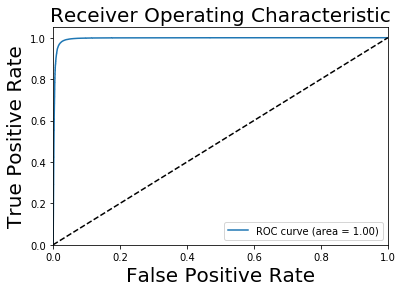

In [31]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_Validation[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver Operating Characteristic',fontsize=20)
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=15)

    plt.ylabel('TRUE LABEL',fontsize=20)
    plt.xlabel('PREDICTED LABEL',fontsize=20)
    #fig.set_size_inches(14, 10)
    plt.tight_layout()

In [33]:
from sklearn.metrics import confusion_matrix

#Y_train_predict = Best_Model.predict_proba(pcTrain)
Y_val_predict = Best_Model.predict_proba(pcValidation)
Y_val_single_col = np.where(Y_Validation==1)[1]
Y_val_mo = pd.get_dummies(Y_val_single_col[:])
Y_val_predict_mo = Y_val_predict.round()
cnf_matrix = confusion_matrix(Y_val_mo.values.argmax(axis=1), Y_val_predict_mo.argmax(axis=1))

Normalized confusion matrix
[[3.57142857e-03 4.03571429e-01 5.92857143e-01]
 [2.19255641e-03 9.68943410e-01 2.88640337e-02]
 [9.73220733e-04 1.16001632e-02 9.87426616e-01]]


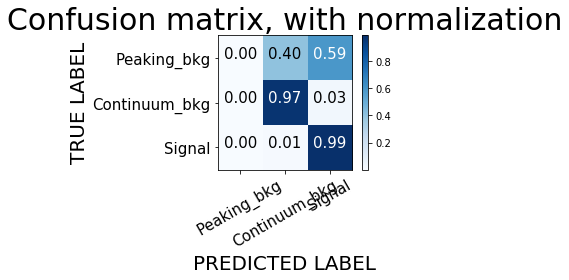

In [34]:
import itertools

plot_confusion_matrix(cnf_matrix, classes=['Peaking_bkg', 'Continuum_bkg', 'Signal'],
                       title='Confusion matrix, with normalization')

### Store the Weights

In [35]:
Best_Model.save("Best_Model.h5")

### Try Loading the model

In [36]:
!ls

Analysis.ipynb	      environment.yml			   README.md
Best_Model.h5	      Keras_Analysis.ipynb		   Scaler.pkl
Data_Challenge.ipynb  Pecularity_in_the_Signal_File.ipynb


In [37]:
from keras.models import load_model

Loaded_Model = load_model('Best_Model.h5')
Loaded_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 5,253
Trainable params: 5,253
Non-trainable params: 0
_________________________________________________________________


In [38]:
Loaded_Model.evaluate(pcTest, Y_Test, verbose=1)

66679/66679 [==============================] - 1s 11us/step


[0.011378803110098997, 0.9800536900673376]

## XGBOOST

In [ ]:
#%%time
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("Training on %i examples with %i features"%X_train.shape)

#Use default parameters and train on full dataset
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000,n_jobs = 1,objective = 'multi:softmax',silent=1,tree_method='approx')
#Train and time classifier
XGBclassifier.fit(X_train, Y_train_single_col)

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= XGBclassifier.predict(X_test)

#Print Results
print("Model Accuracy with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, Y_test_single_col)))